In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis






In [65]:
# chargement  données
df = pd.read_csv("gym_members_exercise_tracking.csv")

# aperçu 
print(df.head())

# résumé statistique 
print(df.describe(include='all').transpose())


   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM   
0   56    Male         88.3        1.71      180      157           60  \
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage   
0                      1.69           1313.0         Yoga            12.6  \
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level   
0              

In [66]:
# on convertit les colonnes qualitatives
categorical_cols = [
    'Gender',
    'Workout_Type',
    'Experience_Level',
    'Workout_Frequency (days/week)'
]
for col in categorical_cols:
    df[col] = df[col].astype('category')


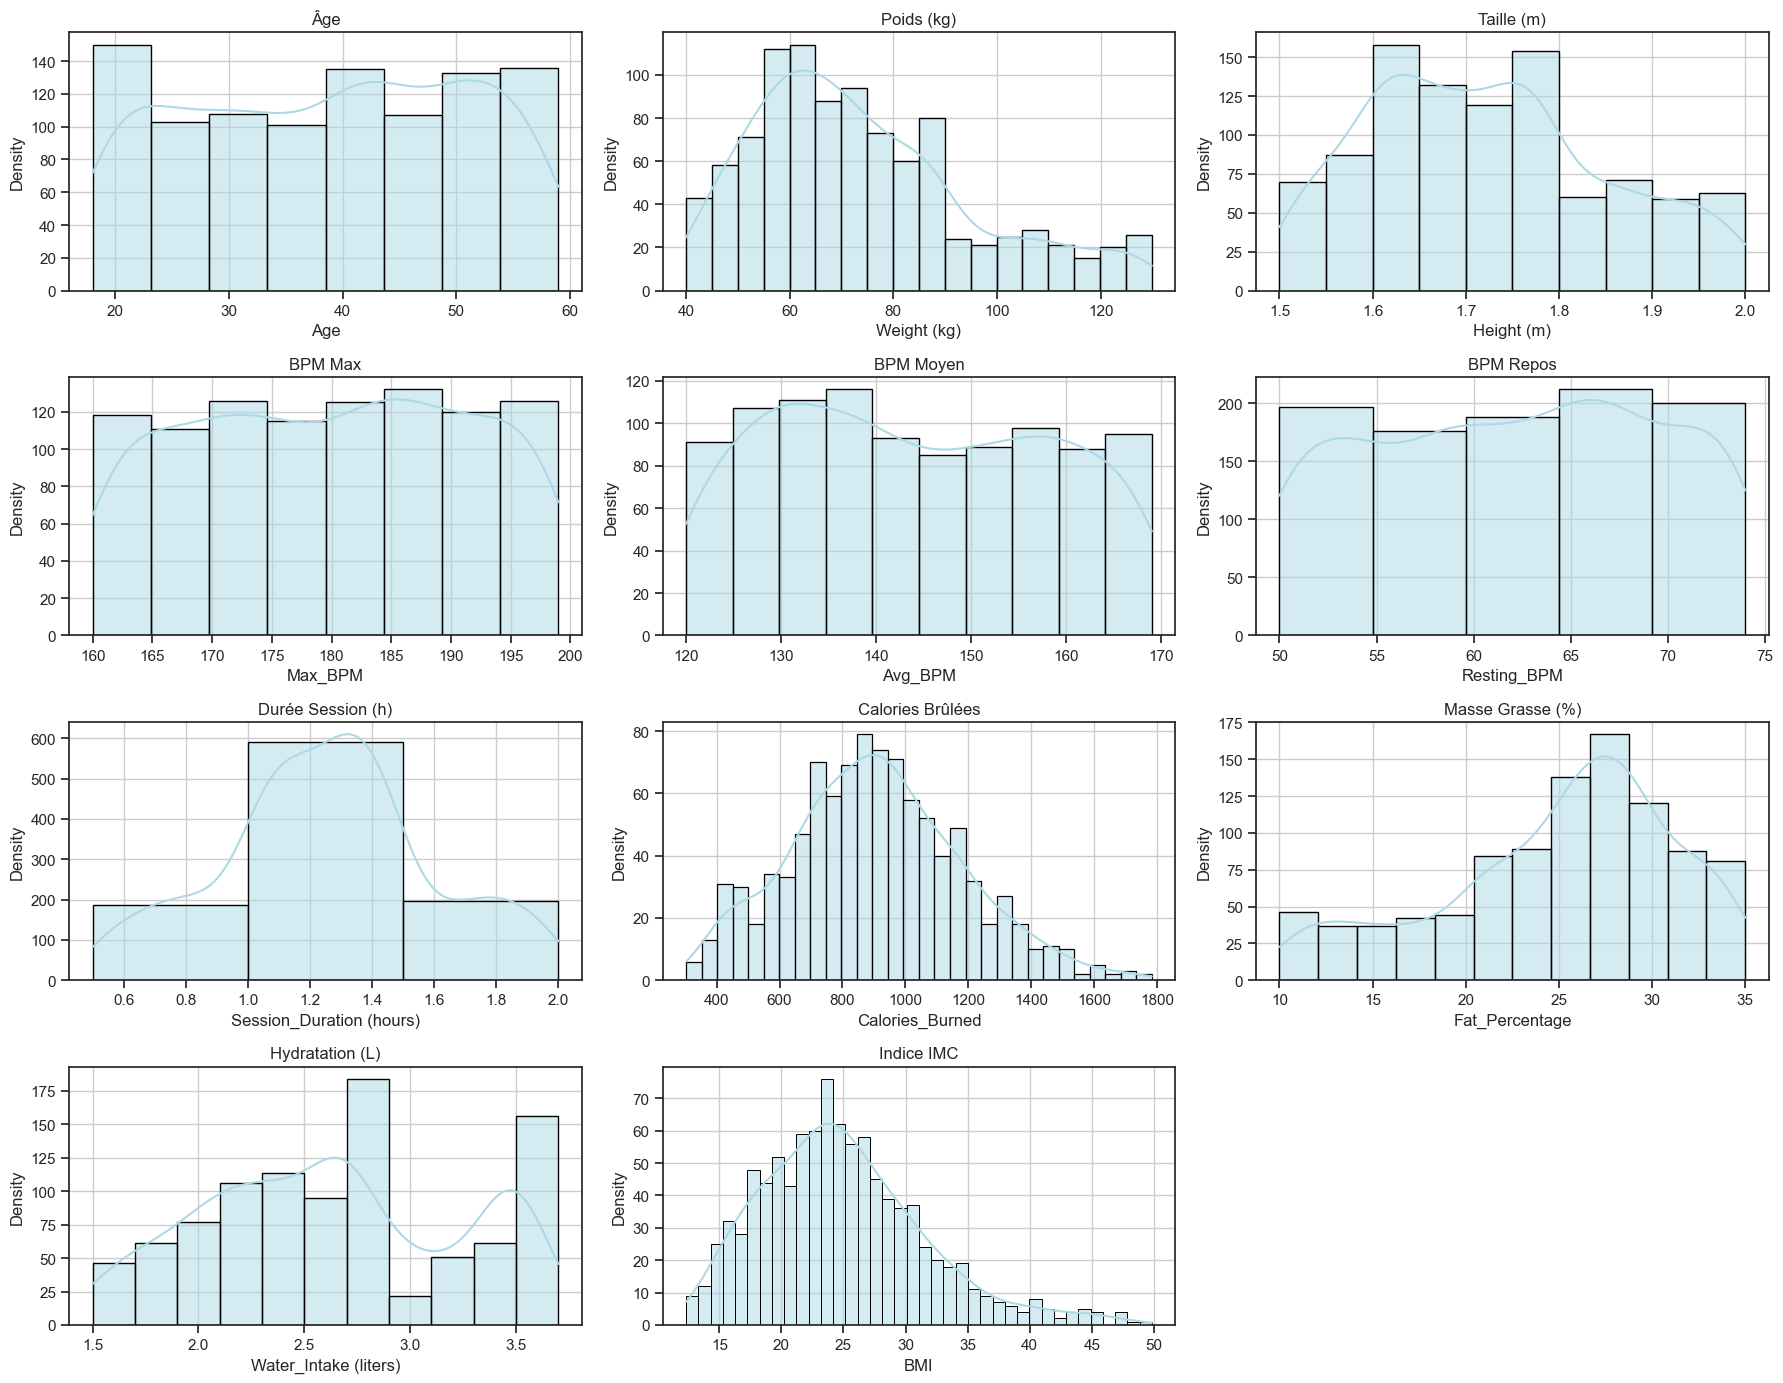

In [67]:
# on trace les histogrammes des variables continues non transformées
# pour détecter les asymétries, valeurs extrêmes etc
plots = [
    ('Age', "Âge", 5),
    ('Weight (kg)', "Poids (kg)", 5),
    ('Height (m)', "Taille (m)", 0.05),
    ('Max_BPM', "BPM Max", 5),
    ('Avg_BPM', "BPM Moyen", 5),
    ('Resting_BPM', "BPM Repos", 5),
    ('Session_Duration (hours)', "Durée Session (h)", 0.5),
    ('Calories_Burned', "Calories Brûlées", 50),
    ('Fat_Percentage', "Masse Grasse (%)", 2),
    ('Water_Intake (liters)', "Hydratation (L)", 0.2),
    ('BMI', "Indice IMC", 1),
]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 14))
axs = axs.flatten()

for ax, (col, title, bw) in zip(axs, plots):
    sns.histplot(df[col], kde=True, binwidth=bw, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

for ax in axs[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()



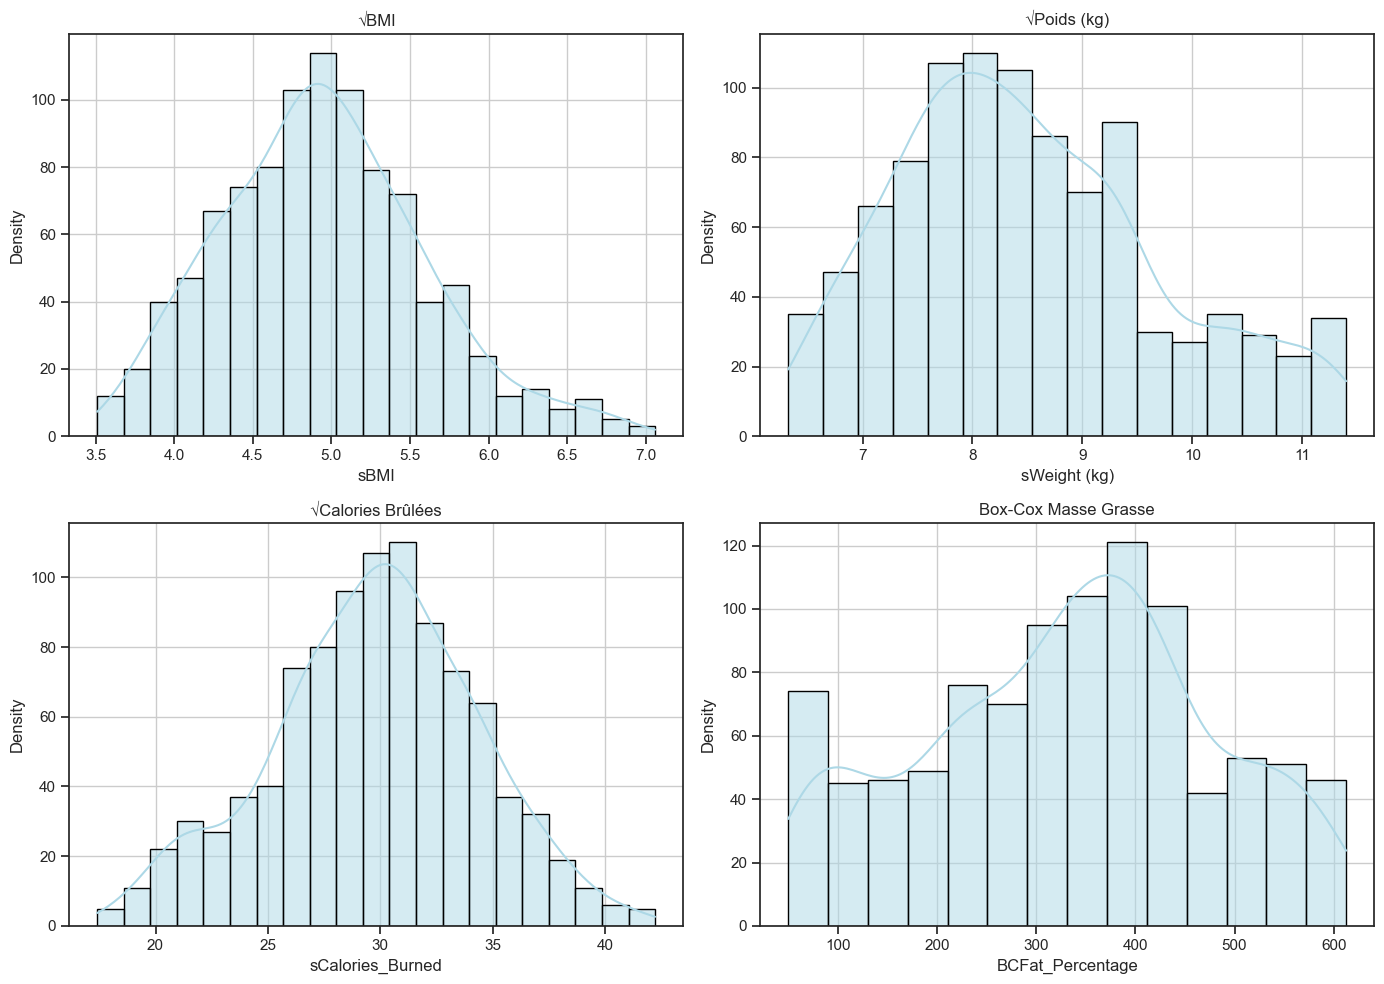

In [68]:
#transformation des variables continues
# on corrige l'asymétrie de certaines variables via racine carrée
# et transformation de type box-cox

df_norm = df.copy()
df_norm['sBMI'] = np.sqrt(df_norm['BMI'])
df_norm['sWeight (kg)'] = np.sqrt(df_norm['Weight (kg)'])
df_norm['sCalories_Burned'] = np.sqrt(df_norm['Calories_Burned'])

lambda_ = 2
df_norm['BCFat_Percentage'] = (df_norm['Fat_Percentage'] ** lambda_) / lambda_

# visualisation des distributions transformées
plots = [
    ('sBMI', '√BMI'),
    ('sWeight (kg)', '√Poids (kg)'),
    ('sCalories_Burned', '√Calories Brûlées'),
    ('BCFat_Percentage', 'Box-Cox Masse Grasse')
]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, (col, title) in zip(axs, plots):
    sns.histplot(df_norm[col], kde=True, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [69]:
# nettoyage et réorganisation du dataset final
columns_to_drop = ['BMI', 'Weight (kg)', 'Calories_Burned', 'Fat_Percentage']
df_norm.drop(columns=columns_to_drop, inplace=True)

ordered_cols = [
    'Age', 'Gender', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'sCalories_Burned', 'Workout_Type',
    'BCFat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)',
    'Experience_Level', 'sBMI'
]
df_norm = df_norm[ordered_cols]

print(df_norm.head())

   Age  Gender  sWeight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM   
0   56    Male      9.396808        1.71      180      157           60  \
1   46  Female      8.654479        1.53      179      151           66   
2   32  Female      8.252272        1.66      167      122           54   
3   25    Male      7.293833        1.70      190      164           56   
4   38    Male      6.789698        1.79      188      158           68   

   Session_Duration (hours)  sCalories_Burned Workout_Type  BCFat_Percentage   
0                      1.69         36.235342         Yoga            79.380  \
1                      1.30         29.715316         HIIT           574.605   
2                      1.11         26.019224       Cardio           557.780   
3                      0.59         23.065125     Strength           414.720   
4                      0.64         23.579652     Strength           426.320   

   Water_Intake (liters) Workout_Frequency (days/week) Experience_Le

In [70]:
# séparation variables quanti et quali
quanti_columns = [
    'Age', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'sCalories_Burned',
    'BCFat_Percentage', 'Water_Intake (liters)', 'sBMI'
]

quali_columns = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level'
]


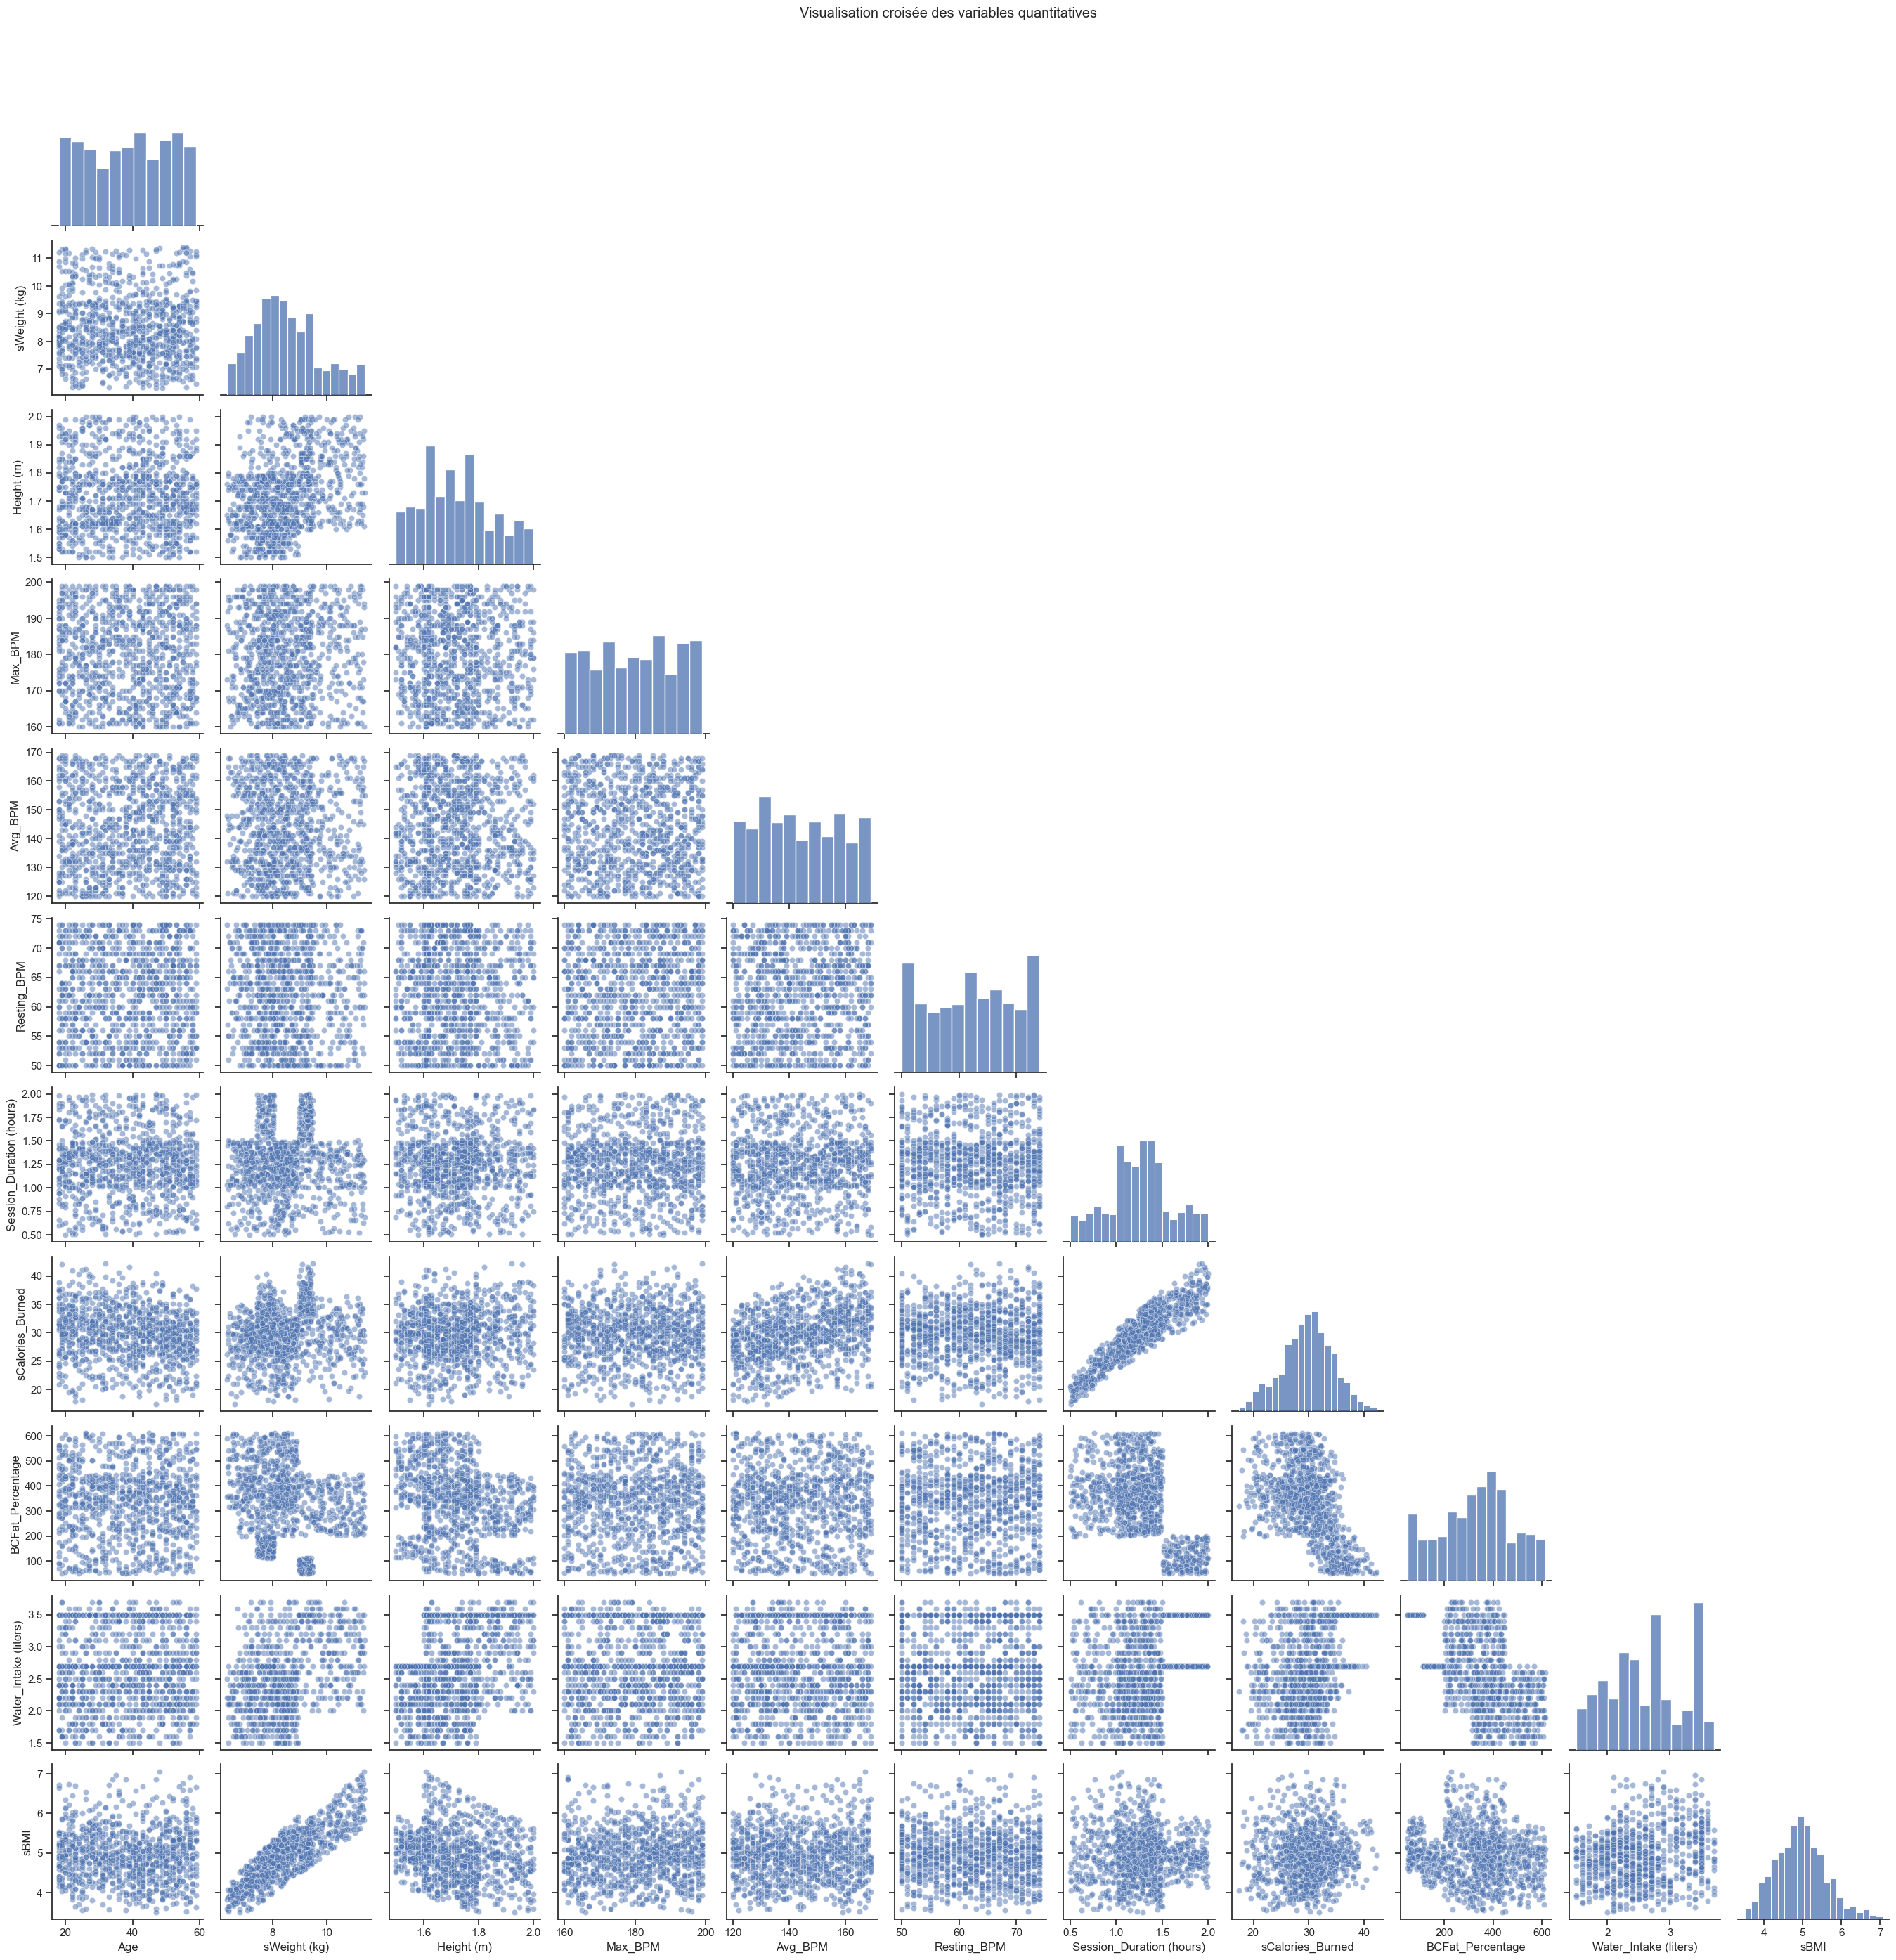

In [71]:
# visualisation croisée des variables quantitatives
sns.set(style="ticks")
pairplot = sns.pairplot(df_norm[quanti_columns], corner=True, plot_kws={'alpha': 0.5})
plt.suptitle("Visualisation croisée des variables quantitatives", y=1.02)
plt.show()


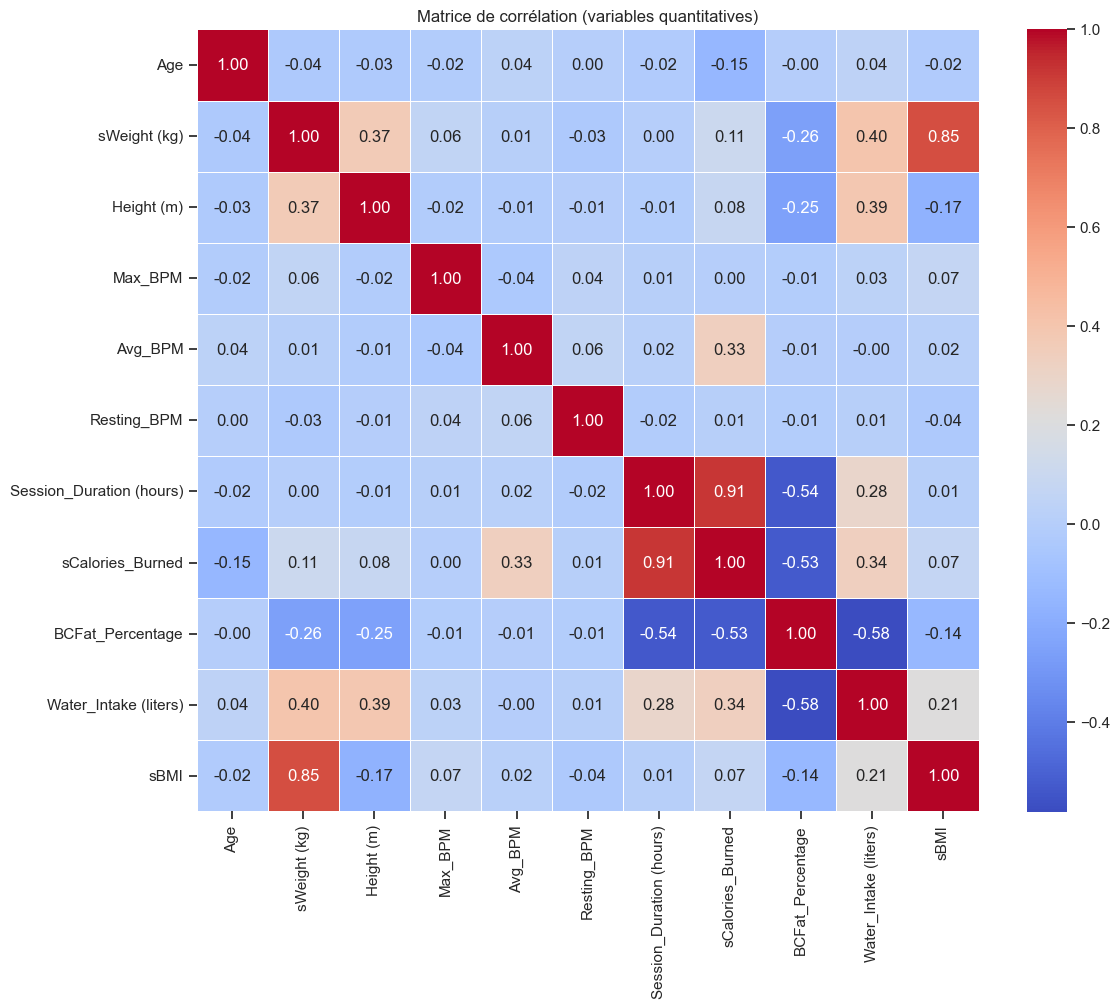

In [72]:
data_acp = df_norm[quanti_columns]

#  matrice de corrélation
corr_matrix = data_acp.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matrice de corrélation (variables quantitatives)")
plt.tight_layout()
plt.show()


Observations :
- sCalories_Burned et Session_Duration (hours) présentent une forte corrélation positive
- sWeight (kg) et sBMI sont également très corrélés
- BCFat_Percentage est négativement corrélé à Session_Duration (hours)
- BCFat_Percentage est aussi négativement corrélé à Water_Intake (liters)


In [73]:
# réduction de dimension via ACP
# on applique une ACP sur les variables quantitatives (hors Age et sWeight),
#pour résumer l'information en 7 dimensions

quanti_columns_r = [col for col in quanti_columns if col not in ['Age', 'sWeight (kg)']]
X_acp_r = df_norm[quanti_columns_r]

X_scaled_r = StandardScaler().fit_transform(X_acp_r)

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled_r)

pca_df = pd.DataFrame(X_pca, columns=[f"Dim.{i+1}" for i in range(7)])


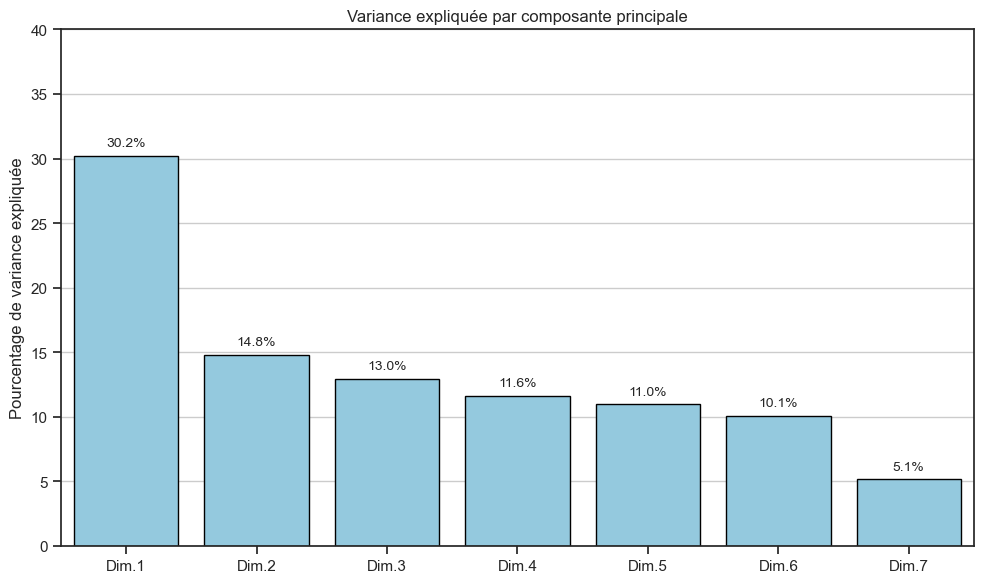

In [74]:
# pourcentage de variance expliquée
explained_var = 100 * pca.explained_variance_ratio_
components = [f"Dim.{i+1}" for i in range(len(explained_var))]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=components, y=explained_var, color="skyblue", edgecolor="black")

for i, val in enumerate(explained_var):
    bars.text(i, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 40)
plt.ylabel("Pourcentage de variance expliquée")
plt.title("Variance expliquée par composante principale")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


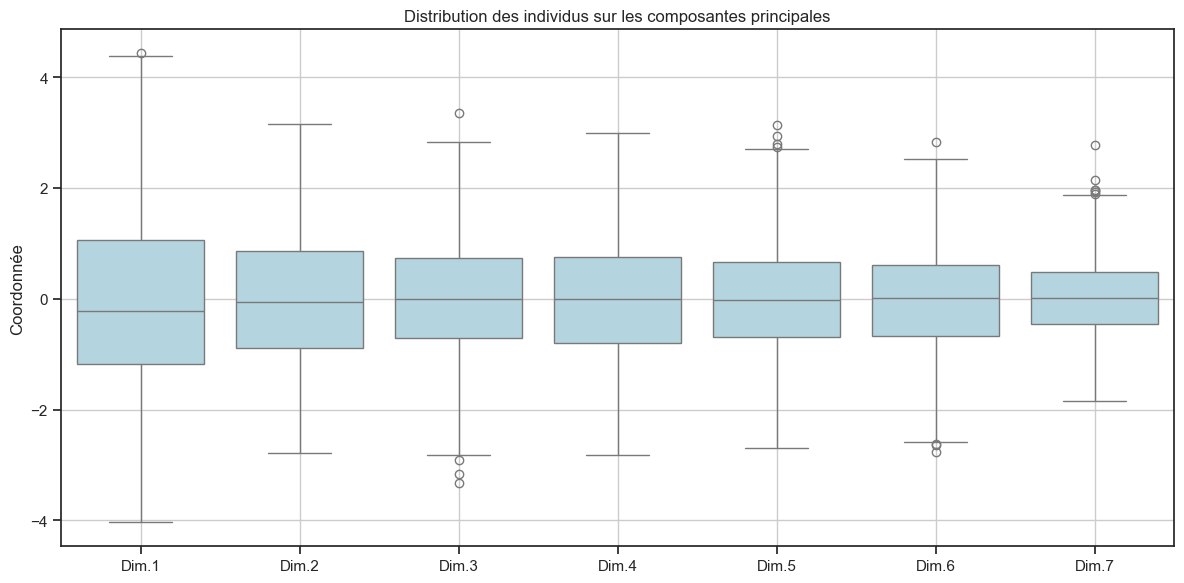

In [75]:
# distribution des individus par axe principal
pca_df = pd.DataFrame(X_pca, columns=[f"Dim.{i+1}" for i in range(7)])

pca_melt = pd.melt(pca_df, var_name="Composante", value_name="Valeur")

plt.figure(figsize=(12, 6))
sns.boxplot(data=pca_melt, x='Composante', y='Valeur', color='lightblue')
plt.xlabel("")
plt.ylabel("Coordonnée")
plt.title("Distribution des individus sur les composantes principales")
plt.grid(True)
plt.tight_layout()
plt.show()


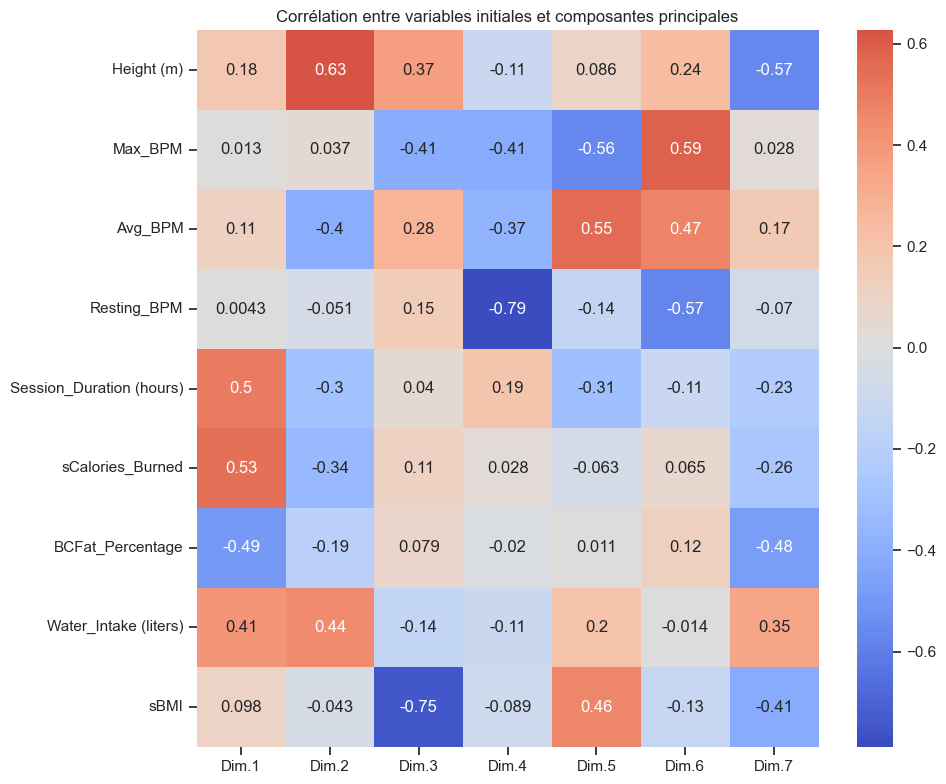

In [76]:
#  corrélations entre variables et composantes principales
loadings_r = pd.DataFrame(pca.components_.T,
                        index=quanti_columns_r, 
                        columns=[f"Dim.{i+1}" for i in range(7)])
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_r, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre variables initiales et composantes principales")
plt.tight_layout()
plt.show()


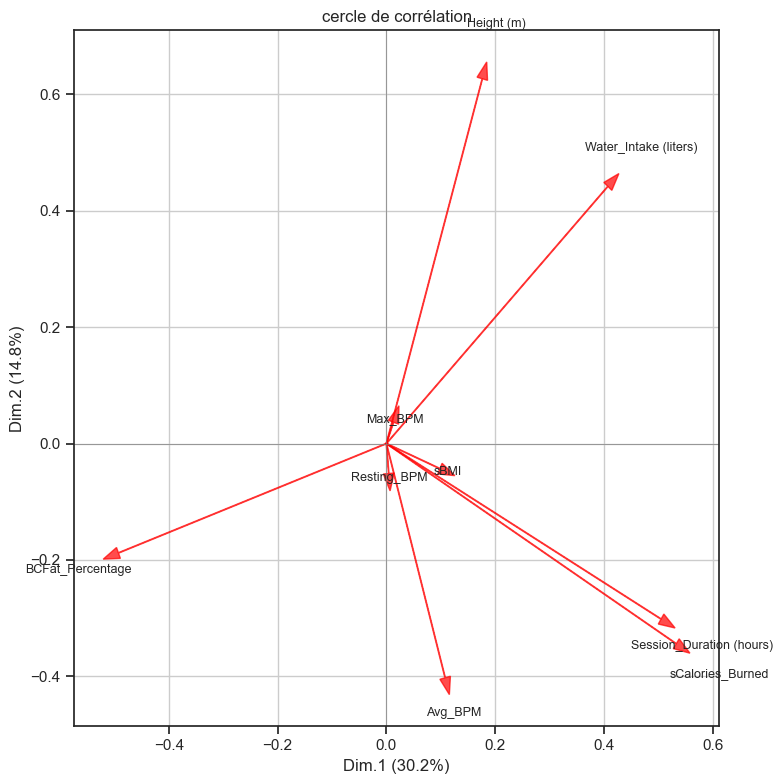

In [77]:
# projection des variables sur le plan factoriel (1,2)

explained_var = 100 * pca.explained_variance_ratio_
dim_labels = [f"Dim.{i+1} ({explained_var[i]:.1f}%)" for i in range(len(explained_var))]

plt.figure(figsize=(8, 8))
for i in range(loadings_r.shape[0]):
    x = loadings_r.iloc[i, 0]
    y = loadings_r.iloc[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.02, color='red', alpha=0.7)
    plt.text(x * 1.15, y * 1.15, loadings_r.index[i], ha='center', va='center', fontsize=9)

plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("cercle de corrélation")
plt.grid(True)
plt.tight_layout()
plt.show()


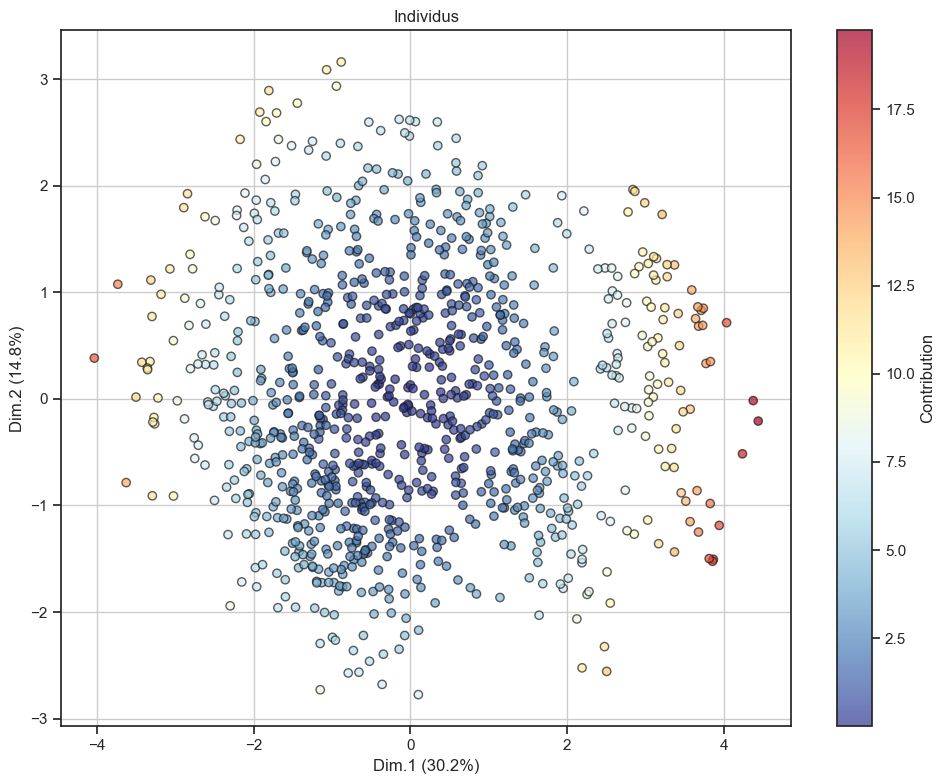

In [78]:
# projection des individus dans le plan (1,2) avec coloration par contribution
pca_df['contrib_12'] = np.square(X_pca[:, 0]) + np.square(X_pca[:, 1])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.2"],
    c=pca_df["contrib_12"], cmap="RdYlBu_r",
    edgecolor='k', alpha=0.7
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("Individus")
cbar = plt.colorbar(scatter)
cbar.set_label("Contribution")
plt.grid(True)
plt.tight_layout()
plt.show()



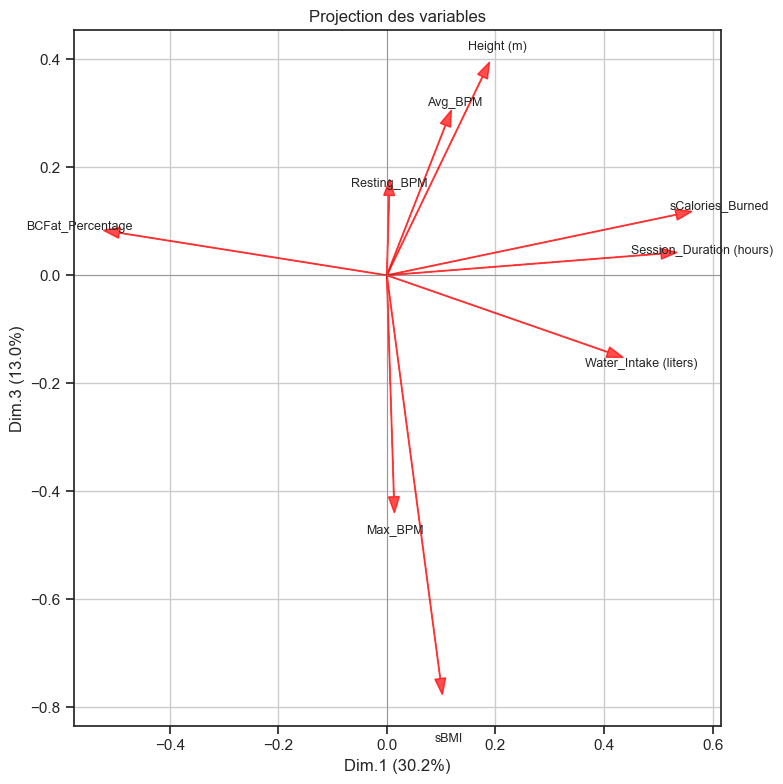

In [79]:
# projection des variables sur le plan factoriel (1,3)

plt.figure(figsize=(8, 8))
for i in range(loadings_r.shape[0]):
    x = loadings_r.iloc[i, 0]
    y = loadings_r.iloc[i, 2]
    plt.arrow(0, 0, x, y, head_width=0.02, color='red', alpha=0.7)
    plt.text(x * 1.15, y * 1.15, loadings_r.index[i], ha='center', va='center', fontsize=9)

plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Projection des variables")
plt.grid(True)
plt.tight_layout()
plt.show()


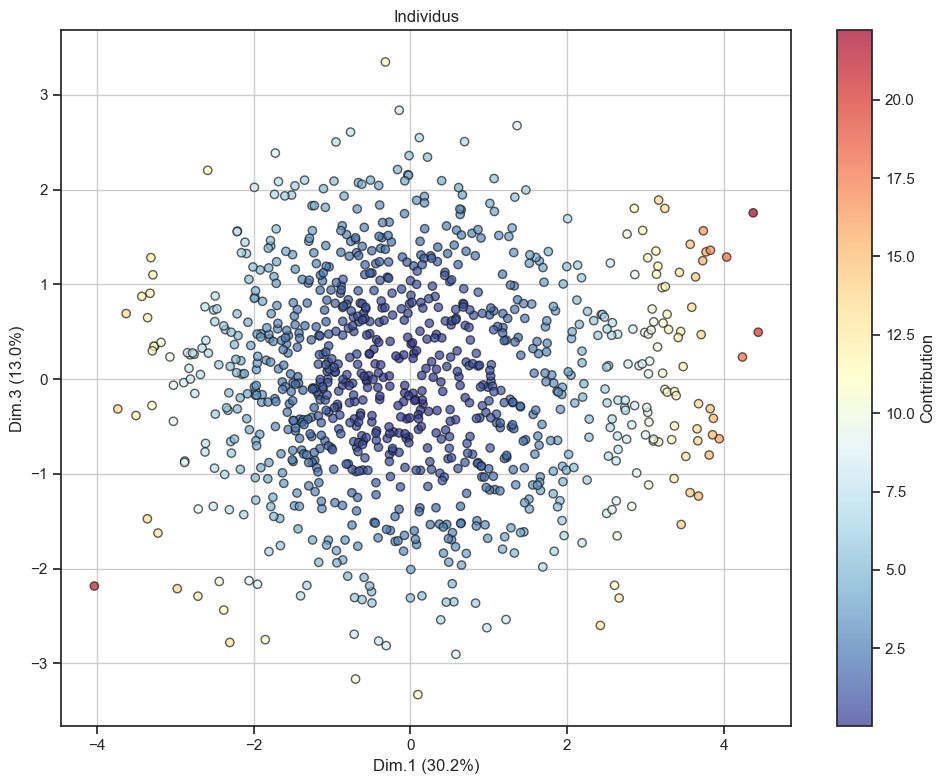

In [80]:
# projection des individus sur le plan (1,3)
pca_df['contrib_13'] = np.square(X_pca[:, 0]) + np.square(X_pca[:, 2])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df["Dim.1"], pca_df["Dim.3"],
                      c=pca_df["contrib_13"], cmap="RdYlBu_r",
                      edgecolor='k', alpha=0.7)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Individus")
cbar = plt.colorbar(scatter)
cbar.set_label("Contribution")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:

df_norm[quanti_columns_r].head()


Height (m)  Max_BPM  Avg_BPM  Resting_BPM  Session_Duration (hours)   
0        1.71      180      157           60                      1.69  \
1        1.53      179      151           66                      1.30   
2        1.66      167      122           54                      1.11   
3        1.70      190      164           56                      0.59   
4        1.79      188      158           68                      0.64   

   sCalories_Burned  BCFat_Percentage  Water_Intake (liters)      sBMI  
0         36.235342            79.380                    3.5  5.495453  
1         29.715316           574.605                    2.1  5.656854  
2         26.019224           557.780                    2.3  4.970915  
3         23.065125           414.720                    2.1  4.290688  
4         23.579652           426.320                    2.8  3.793415

In [82]:
# projection des individus dans le plan (1,2) avec coloration  par sCalories_Burned 
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.2"],
    c=df_norm["sCalories_Burned"], cmap="coolwarm",
    edgecolor='k', s=60, alpha=0.8
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("Projection ACP — coloration par sCalories_Burned")
cbar = plt.colorbar(scatter)
cbar.set_label("sCalories_Burned")
plt.grid(True)
plt.tight_layout()
plt.show()


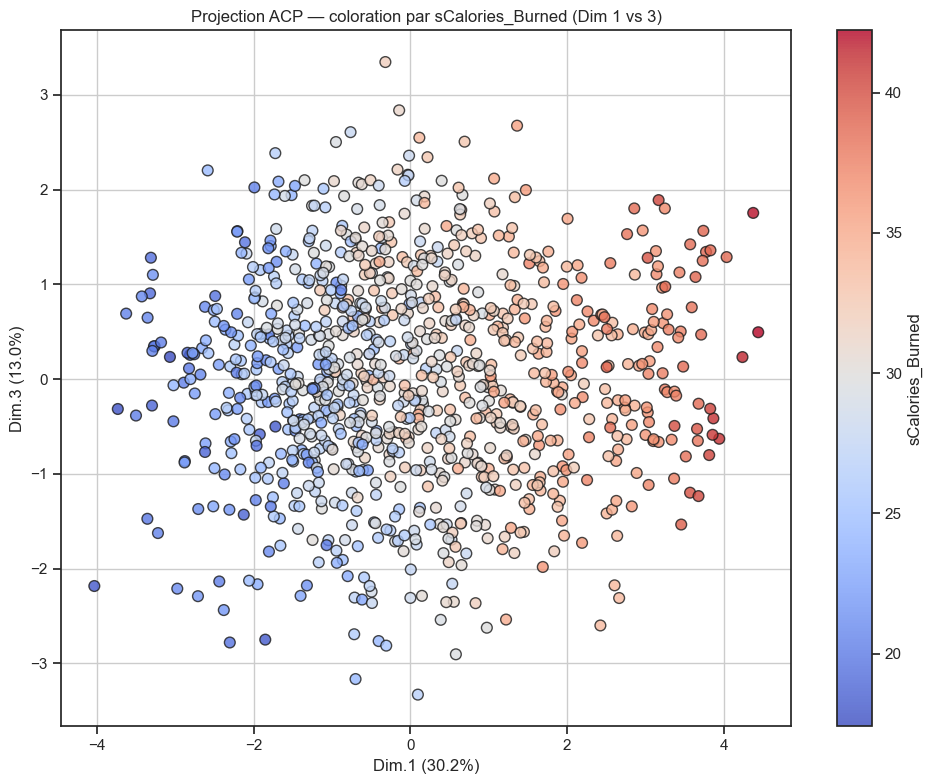

In [83]:
# projection des individus dans le plan (1,2) avec coloration  par sCalories_Burned 
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.3"],
    c=df_norm["sCalories_Burned"], cmap="coolwarm",
    edgecolor='k', s=60, alpha=0.8
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Projection ACP — coloration par sCalories_Burned (Dim 1 vs 3)")
cbar = plt.colorbar(scatter)
cbar.set_label("sCalories_Burned")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.2 Prédiction du niveau d'entraînement (classification)

**Fonctions préalables**

In [84]:
# on calcule le pourcentage d'erreur à partir d'une matrice de confusion
def erreur_pourcentage(conf_matrix):
    total = np.sum(conf_matrix)
    correct = np.trace(conf_matrix)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"Pourcentage d'erreur : {pourcentage:.2f} %")

In [85]:
#validation croisée à 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [86]:
# tracer les courbes ROC par classe
def plot_roc_curves(y_true, y_probs, class_names, model_name="Modèle"):
   
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(8, 6))
    colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC par classe — {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [87]:
# superposition des courbes ROC de deux modèles
def plot_superposed_roc_curves(y_true, probs_1, name_1, probs_2, name_2, class_names):
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(10, 8))
    colors1 = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
    colors2 = plt.cm.Dark2(np.linspace(0, 1, len(class_names)))
    
    for i, class_name in enumerate(class_names):
        fpr1, tpr1, _ = roc_curve(y_bin[:, i], probs_1[:, i])
        fpr2, tpr2, _ = roc_curve(y_bin[:, i], probs_2[:, i])
        plt.plot(fpr1, tpr1, color=colors1[i], lw=2, linestyle='-', label=f"{name_1} — {class_name}")
        plt.plot(fpr2, tpr2, color=colors2[i], lw=2, linestyle='--', label=f"{name_2} — {class_name}")
    
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC superposées : {name_1} vs {name_2}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Découpage du dataset**

In [88]:
# découpage du dataset original en train/test
# on effectue un split 80/20 stratifié selon Experience_Level

X = df.drop(columns=["Experience_Level"])
y = df["Experience_Level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234
)

data_exp = X_train.copy()
data_exp["Experience_Level"] = y_train
data_test = X_test.copy()
data_test["Experience_Level"] = y_test

# même split sur le dataset transformé

X_norm = df_norm.drop(columns=["Experience_Level"])
y_norm = df_norm["Experience_Level"]

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y_norm, test_size=0.2, stratify=y_norm, random_state=1234
)

data_exp_norm = X_train_norm.copy()
data_exp_norm["Experience_Level"] = y_train_norm
data_test_norm = X_test_norm.copy()
data_test_norm["Experience_Level"] = y_test_norm

quanti_columns_bis_norm = [
    'Age', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'sCalories_Burned',
    'BCFat_Percentage', 'Water_Intake (liters)', 'sBMI'
]

# standardisation 
scaler_norm = StandardScaler()
data_exp_norm[quanti_columns_bis_norm] = scaler_norm.fit_transform(data_exp_norm[quanti_columns_bis_norm])
data_test_norm[quanti_columns_bis_norm] = scaler_norm.transform(data_test_norm[quanti_columns_bis_norm])


In [89]:
print(data_exp_norm.describe())
print(data_test_norm.describe())

                Age  sWeight (kg)    Height (m)       Max_BPM       Avg_BPM   
count  7.780000e+02  7.780000e+02  7.780000e+02  7.780000e+02  7.780000e+02  \
mean   2.146241e-16  4.566470e-16  1.348821e-15  5.479764e-16 -4.840458e-16   
std    1.000643e+00  1.000643e+00  1.000643e+00  1.000643e+00  1.000643e+00   
min   -1.687534e+00 -1.836692e+00 -1.774464e+00 -1.724068e+00 -1.670253e+00   
25%   -8.710530e-01 -7.474491e-01 -8.304562e-01 -8.566264e-01 -8.958447e-01   
50%    2.707611e-02 -1.239130e-01 -4.378273e-02  9.755930e-02 -5.103600e-02   
75%    9.252053e-01  6.339251e-01  5.855560e-01  8.782567e-01  8.641734e-01   
max    1.660038e+00  2.384913e+00  2.158903e+00  1.658954e+00  1.779383e+00   

        Resting_BPM  Session_Duration (hours)  sCalories_Burned   
count  7.780000e+02              7.780000e+02      7.780000e+02  \
mean  -3.150864e-16              2.283235e-17     -1.050288e-16   
std    1.000643e+00              1.000643e+00      1.000643e+00   
min   -1.622345e+00 

# 2.2.1 Régression multinomiale

**Régression multinomiale**

In [90]:
# régression multinomiale de base (sans pénalité)
# on encode les variables qualitatives, entraîne le modèle, 
# puis affiche les coefficients et la matrice de confusion

def train_multinom_model(train_df, test_df, target_col="Experience_Level"):
    
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    categorical_cols = ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)']
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

   
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

  
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=1e10,  
        max_iter=1000,
        random_state=42
    )

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    coef_df = pd.DataFrame(model.coef_, columns=X_train_encoded.columns)
    coef_df.index = model.classes_

    return model, y_pred, coef_df

In [91]:
model, y_pred, coef_df = train_multinom_model(
    data_exp_norm,
    data_test_norm,
    target_col="Experience_Level"
)

print(coef_df)

        Age  sWeight (kg)  Height (m)   Max_BPM  Avg_BPM  Resting_BPM   
1 -0.472958      0.179745    0.750489  0.199940  1.59902     0.055461  \
2 -0.185299      0.155169    0.758106  0.253589  0.83459     0.127793   
3  0.658257     -0.334915   -1.508596 -0.453528 -2.43361    -0.183254   

   Session_Duration (hours)  sCalories_Burned  BCFat_Percentage   
1                 -5.758971         -4.607869          8.335714  \
2                 -6.821713         -1.675639          8.377180   
3                 12.580685          6.283508        -16.712895   

   Water_Intake (liters)      sBMI  Gender_Male  Workout_Type_HIIT   
1              -1.064542 -0.246622     6.587852           0.792995  \
2              -1.218296 -0.235604     6.218803           0.865256   
3               2.282839  0.482226   -12.806655          -1.658251   

   Workout_Type_Strength  Workout_Type_Yoga  Workout_Frequency (days/week)_3   
1               1.599887           1.192695                        -6.357045 

In [92]:
# matrice de confusion
conf_matrix_multinom = confusion_matrix(y_test_norm, y_pred, labels=model.classes_)
conf_matrix_df = pd.DataFrame(conf_matrix_multinom, 
                              index=[f"Vrai_{c}" for c in model.classes_],
                              columns=[f"Prévu_{c}" for c in model.classes_])
print("Matrice de confusion :")
print(conf_matrix_df)

erreur_pourcentage(conf_matrix_multinom)

Matrice de confusion :
        Prévu_1  Prévu_2  Prévu_3
Vrai_1       59       16        0
Vrai_2        7       75        0
Vrai_3        0        0       38
Pourcentage d'erreur : 11.79 %


**Ridge** (pénalisation de la complexité)

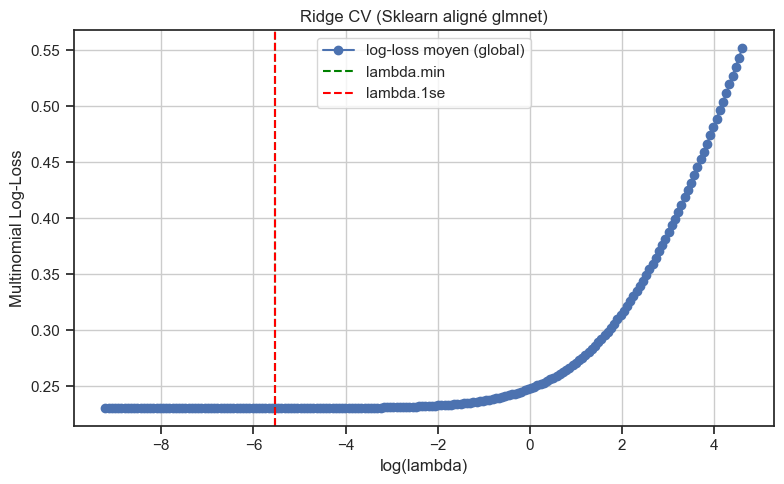

Best lambda (sklearn, global log-loss) : 0.003963


In [93]:
# régression multinomiale Ridge (log-loss) avec CV


categorical_cols = ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)']
X_train_raw = pd.get_dummies(data_exp_norm.drop(columns=['Experience_Level']), columns=categorical_cols, drop_first=True)
y_train = data_exp_norm['Experience_Level']

# grille de lambdas
lambda_values = np.logspace(-4, 2, 200)
C_values = 1 / lambda_values

ridge_cv = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty="l2",
    solver="saga",
    multi_class="multinomial",
    scoring="neg_log_loss",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
ridge_cv.fit(X_train_raw, y_train)

true_Cs = ridge_cv.Cs_
true_lambdas = 1 / np.array(true_Cs)

logloss_all = np.array([
    -ridge_cv.scores_[cls].mean(axis=0) for cls in ridge_cv.scores_.keys()
])
mean_logloss = logloss_all.mean(axis=0)
std_logloss = logloss_all.std(axis=0)

# lambda
min_loss = mean_logloss.min()
best_index = mean_logloss.argmin()
best_lambda = true_lambdas[best_index]


plt.figure(figsize=(8, 5))
plt.plot(np.log(true_lambdas), mean_logloss, marker='o', label="log-loss moyen (global)")
plt.axvline(np.log(best_lambda), color='green', linestyle='--', label='lambda.min')
plt.axvline(np.log(lambda_1se), color='red', linestyle='--', label='lambda.1se')
plt.xlabel("log(lambda)")
plt.ylabel("Multinomial Log-Loss")
plt.title("Ridge CV (Sklearn aligné glmnet)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best lambda (sklearn, global log-loss) : {best_lambda:.6f}")



In [94]:
# entraînement du modèle final Ridge multinomial avec le meilleur lambda trouvé par CV
from sklearn.linear_model import LogisticRegression
import pandas as pd

final_ridge_model = LogisticRegression(
    C=chosen_C,  # best_C = 1 / lambda_min
    penalty='l2',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
final_ridge_model.fit(X_train_scaled, y_train)
proba_preds = final_ridge_model.predict_proba(X_test_scaled)

# affichage des coefficients par classe 
for i, class_label in enumerate(final_ridge_model.classes_):
    print(f"\nCoefficients pour la classe {class_label}:")
    print(pd.Series(final_ridge_model.coef_[i], index=X_train_encoded.columns))

print("\nIntercepts pour chaque classe :")
print(final_ridge_model.intercept_)

final_ridge_model = LogisticRegression(
    C=chosen_C,
    penalty='l2',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
final_ridge_model.fit(X_train_scaled, y_train)
proba_preds = final_ridge_model.predict_proba(X_test_scaled)

for i, class_label in enumerate(final_ridge_model.classes_):
    print(f"\nCoefficients pour la classe {class_label}:")
    print(pd.Series(final_ridge_model.coef_[i], index=X_train_encoded.columns))


print("\nIntercepts (biais) pour chaque classe :")
print(final_ridge_model.intercept_)


NameError: name 'chosen_C' is not defined

In [ ]:
# prédiction des classes
# construction de la matrice de confusion et calcul de l’erreur globale
pred_class = np.argmax(proba_preds, axis=1)

true_class = y_test.reset_index(drop=True).astype('category').cat.codes

conf_matrix = confusion_matrix(true_class, pred_class)
print("Matrice de confusion :")
print(pd.DataFrame(conf_matrix,
                   index=[f"Réel_{c}" for c in final_ridge_model.classes_],
                   columns=[f"Prévu_{c}" for c in final_ridge_model.classes_]))

total = len(true_class)
erreurs = np.sum(pred_class != true_class)
print(f"\nPourcentage d'erreur : {100 * erreurs / total:.2f} %")


Matrice de confusion :
        Prévu_1  Prévu_2  Prévu_3
Réel_1       59       16        0
Réel_2        8       74        0
Réel_3        0        1       37

Pourcentage d'erreur : 12.82 %


**Lasso** (sélection de variables)

In [ ]:
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

lambda_grid = np.logspace(-1, 0, 50)
log_losses = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for lmbda in lambda_grid:
    fold_losses = []
    for train_idx, val_idx in cv.split(X_encoded, y_encoded):
        X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
        y_train, y_val = y_encoded.iloc[train_idx], y_encoded.iloc[val_idx]

        model = LogisticRegression(
            penalty='l1',
            C=1 / lmbda,
            solver='saga',
            multi_class='multinomial',
            max_iter=1000,
            tol=1e-3
        )
        try:
            model.fit(X_train, y_train)
            proba = model.predict_proba(X_val)
            loss = log_loss(y_val, proba, labels=np.unique(y_encoded))
            fold_losses.append(loss)
        except Exception:
            fold_losses.append(np.nan)

    log_losses.append(np.nanmean(fold_losses))

log_losses = np.array(log_losses)
lambda_min = lambda_grid[np.nanargmin(log_losses)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(lambda_grid), log_losses, marker='o', label="log-loss moyen")
plt.axvline(np.log(lambda_min), color='green', linestyle='--', label='lambda.min')
plt.xlabel("log(lambda)")
plt.ylabel("Multinomial Log-Loss")
plt.title("Lasso CV manuelle — style glmnet")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"lambda.min = {lambda_min:.6f}")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    index=X_train_encoded.index,
    columns=X_train_encoded.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    index=X_test_encoded.index,
    columns=X_test_encoded.columns
)
X_train_scaled, y_train_aligned = X_train_scaled.align(y_train, join='inner', axis=0)

final_lasso_model = LogisticRegression(
    penalty='l1',
    C=1 / lambda_min,
    solver='saga',
    multi_class='multinomial',
    max_iter=10000,
    random_state=42
)
final_lasso_model.fit(X_train_scaled, y_train_aligned)

proba_preds = final_lasso_model.predict_proba(X_test_scaled)
pred_class = np.argmax(proba_preds, axis=1)
true_class = y_test.reset_index(drop=True).astype('category').cat.codes

conf_matrix = confusion_matrix(true_class, pred_class)
print("Matrice de confusion :")
print(pd.DataFrame(conf_matrix,
                   index=[f"Réel_{c}" for c in final_lasso_model.classes_],
                   columns=[f"Prévu_{c}" for c in final_lasso_model.classes_]))

def erreur_pourcentage(conf_matrix):
    total = np.sum(conf_matrix)
    correct = np.trace(conf_matrix)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"Pourcentage d'erreur : {pourcentage:.2f} %")

erreur_pourcentage(conf_matrix)
def plot_roc_curves(y_test, y_score, model_name="Modèle"):
    y_test = np.array(y_test)
    n_classes = y_score.shape[1]
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        y_bin = (y_test == i).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Classe {i+1} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves(true_class, proba_preds, model_name="Régression Lasso Multinomial")


NameError: name 'warnings' is not defined

**Elastic net** (Ridge + Lasso)

In [ ]:
# elastic Net multinomial : sélection conjointe de alpha et lambda via classification error (zero-one loss)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import zero_one_loss, confusion_matrix

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

y_encoded = y_encoded.astype(int)
y_test = y_test.astype(int) 

alpha_list = np.round(np.linspace(0.1, 0.9, 9), 2)
lambda_grid = np.logspace(-6, 1, 60)
results = []

for alpha in alpha_list:
    for lmbda in lambda_grid:
        fold_losses = []
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

        for train_idx, val_idx in cv.split(X_encoded, y_encoded):
            X_train = X_encoded.iloc[train_idx]
            X_val = X_encoded.iloc[val_idx]
            y_train = y_encoded.iloc[train_idx]
            y_val = y_encoded.iloc[val_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            model = LogisticRegression(
                penalty="elasticnet",
                l1_ratio=alpha,
                solver="saga",
                C=1 / lmbda,
                multi_class="multinomial",
                class_weight='balanced',
                max_iter=10000,
                tol=1e-3
            )
            try:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_val_scaled)
                loss = zero_one_loss(y_val, y_pred)
                fold_losses.append(loss)
            except:
                fold_losses.append(np.nan)

        results.append((alpha, lmbda, np.nanmean(fold_losses)))

results_df = pd.DataFrame(results, columns=["alpha", "lambda", "cv_error"])
best_row = results_df.loc[results_df["cv_error"].idxmin()]
best_alpha = best_row["alpha"]
best_lambda = best_row["lambda"]

print("\nMeilleur alpha :", best_alpha)
print("Meilleur lambda :", best_lambda)
print("Erreur de classification moyenne (zero-one loss) :", best_row['cv_error'])

scaler_final = StandardScaler()
X_encoded_scaled = pd.DataFrame(
    scaler_final.fit_transform(X_encoded),
    columns=X_encoded.columns
)
X_test_encoded_scaled = pd.DataFrame(
    scaler_final.transform(X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)),
    columns=X_encoded.columns
)

final_model = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=best_alpha,
    solver="saga",
    C=1 / best_lambda,
    multi_class="multinomial",
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
final_model.fit(X_encoded_scaled, y_encoded)


y_pred = final_model.predict(X_test_encoded_scaled)
true_class = y_test.reset_index(drop=True)
pred_class = pd.Series(y_pred)

conf_matrix = confusion_matrix(true_class, pred_class)
print("\nMatrice de confusion :")
print(pd.DataFrame(conf_matrix,
                   index=[f"Réel_{c}" for c in final_model.classes_],
                   columns=[f"Prévu_{c}" for c in final_model.classes_]))

def erreur_pourcentage(conf_matrix):
    total = np.sum(conf_matrix)
    correct = np.trace(conf_matrix)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"\nPourcentage d'erreur : {pourcentage:.2f} %")

erreur_pourcentage(conf_matrix)

print("\nCoefficients non nuls du modèle final (Elastic Net multinomial) :")
for i, class_label in enumerate(final_model.classes_):
    coef = pd.Series(final_model.coef_[i], index=X_encoded.columns)
    actifs = coef[coef != 0]
    print(f"\nClasse {class_label} — {len(actifs)} coefficients non nuls :")
    print(actifs.sort_values(ascending=False))



Meilleur alpha : 0.7
Meilleur lambda : 7.609496685459884
Erreur de classification moyenne (zero-one loss) : 0.12717282717282719

Matrice de confusion :
        Prévu_1  Prévu_2  Prévu_3
Réel_1       61       14        0
Réel_2       12       70        0
Réel_3        2       16       20

Pourcentage d'erreur : 22.56 %

Coefficients non nuls du modèle final (Elastic Net multinomial) :

Classe 1 — 4 coefficients non nuls :
Workout_Type_Yoga                 -0.014399
sCalories_Burned                  -0.479607
Session_Duration (hours)          -0.812772
Workout_Frequency (days/week)_4   -2.104683
dtype: float64

Classe 2 — 7 coefficients non nuls :
Workout_Frequency (days/week)_3    1.351650
Workout_Frequency (days/week)_4    0.686707
Gender_Male                        0.131868
BCFat_Percentage                   0.116640
Workout_Type_Yoga                  0.007323
sWeight (kg)                       0.001292
Water_Intake (liters)             -0.111272
dtype: float64

Classe 3 — 5 coeffici

In [ ]:
#j'arrive pas a avoir un meilleur résultat

# 2.2.2 Classification par analyse discriminante

**LDA**

In [ ]:

X_train_encoded, y_train = X_train_encoded.align(y_train, join='inner', axis=0)

lda = LinearDiscriminantAnalysis()
cv_scores = cross_val_score(lda, X_train_encoded, y_train, cv=10, scoring='accuracy')
cv_error = 1 - np.mean(cv_scores)
print(f"Erreur CV LDA : {cv_error:.4f}")

lda.fit(X_train_encoded, y_train)
predictions_lda = lda.predict(X_test_encoded)
probabilities_lda = lda.predict_proba(X_test_encoded)

conf_matrix_lda = confusion_matrix(y_test, predictions_lda)
conf_df_lda = pd.DataFrame(conf_matrix_lda,
                           index=[f"Actual {cls}" for cls in np.unique(y_test)],
                           columns=[f"Pred {cls}" for cls in np.unique(y_test)])
print(conf_df_lda)

error_rate_lda = 100 * (1 - np.trace(conf_matrix_lda) / np.sum(conf_matrix_lda))
print(f"Taux d'erreur LDA : {error_rate_lda:.2f}%")

plot_roc_curves(y_test, probabilities_lda, model_name="LDA")


Erreur CV LDA : 0.1682
          Pred 1  Pred 2  Pred 3
Actual 1      58      17       0
Actual 2       9      73       0
Actual 3       0       9      29
Taux d'erreur LDA : 17.95%


**kNN**

In [ ]:
#  modèle kNN avec sélection automatique du nombre optimal de voisins (k)
# via validation croisée (10 folds), en testant 20 valeurs différentes de k 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_encoded.index)
X_train_final, y_train_final = X_train_scaled_df.align(y_train, join='inner', axis=0)

param_grid = {"n_neighbors": list(range(1, 15))}
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# recherche de k optimal
knnOpt = knn_grid.fit(X_train_final, y_train_final)
best_k = knnOpt.best_params_["n_neighbors"]
cv_accuracy = knnOpt.best_score_
cv_error = 1 - cv_accuracy

print(f"Meilleur k = {best_k}")
print(f" Accuracy moyenne (CV) = {cv_accuracy:.4f}")
print(f" Erreur moyenne (CV) = {cv_error:.4f}")

X_test_final = pd.DataFrame(X_test_scaled, index=X_test_encoded.index)
y_pred_test = knnOpt.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1 - test_accuracy

print(f"\n Accuracy test = {test_accuracy:.4f}")
print(f" Taux d'erreur test = {100 * test_error:.2f}%")

conf_matrix = pd.crosstab(
    y_pred_test, y_test,
    rownames=['Prévu'], colnames=['Réel']
)
print("\n Matrice de confusion :")
print(conf_matrix)

scores = knnOpt.cv_results_['mean_test_score']
plt.figure(figsize=(8, 5))
plt.plot(param_grid["n_neighbors"], scores, marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Accuracy moyenne (CV)")
plt.title("Validation croisée pour KNN")
plt.grid(True)
plt.tight_layout()
plt.show()


# k-Nearest Neighbors (k-NN)
prob_knn = knnOpt.predict_proba(X_test_encoded)


Meilleur k = 1
 Accuracy moyenne (CV) = 0.8302
 Erreur moyenne (CV) = 0.1698

 Accuracy test = 0.8513
 Taux d'erreur test = 14.87%

 Matrice de confusion :
Réel    1   2   3
Prévu            
1      64  13   0
2      11  68   4
3       0   1  34


****SVM kernel radial****

In [ ]:
# entraînement d’un SVM à noyau radial (RBF) avec recherche des hyperparamètres C (pénalisation)
# et gamma (largeur du noyau) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_encoded.index)
X_train_final, y_train_final = X_train_scaled_df.align(y_train, join='inner', axis=0)

param_grid = {
    "C": [2, 3, 4, 5, 6, 7, 8, 9],
    "gamma": np.arange(0.01, 0.051, 0.005),
    "kernel": ["rbf"]
}

svm_grid = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1
)

svmOpt = svm_grid.fit(X_train_final, y_train_final)

best_C = svmOpt.best_params_["C"]
best_gamma = svmOpt.best_params_["gamma"]
cv_accuracy = svmOpt.best_score_
cv_error = 1 - cv_accuracy

print(f"Meilleur C : {best_C}")
print(f"Meilleur gamma : {best_gamma}")
print(f"Erreur moyenne (validation croisée) : {cv_error:.4f}")

X_test_final = pd.DataFrame(X_test_scaled, index=X_test_encoded.index)
y_pred_svm = svmOpt.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_pred_svm)
test_error = 1 - test_accuracy

print(f"Accuracy sur le test : {test_accuracy:.4f}")
print(f"Taux d'erreur sur le test : {100 * test_error:.2f}%")

conf_matrix_svm = pd.crosstab(y_pred_svm, y_test, rownames=["Prévu"], colnames=["Réel"])
print("Matrice de confusion :")
print(conf_matrix_svm)

prob_svm = svmOpt.predict_proba(X_test_scaled)


Meilleur C : 9
Meilleur gamma : 0.01
Erreur moyenne (validation croisée) : 0.1326
Accuracy sur le test : 0.8667
Taux d'erreur sur le test : 13.33%
Matrice de confusion :
Réel    1   2   3
Prévu            
1      56   4   0
2      19  78   3
3       0   0  35


****SVM kernel polynomial****

In [ ]:
# entraînement d’un SVM à noyau radial
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_encoded.index)
X_train_final, y_train_final = X_train_scaled_df.align(y_train, join='inner', axis=0)

# SVM polynomial
param_grid_poly = {
    "C": [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
    "gamma": np.arange(0.06, 0.201, 0.02),
    "kernel": ["poly"]
    # degree=3 et coef0=0 sont utilisés par défaut
}

svm_poly_grid = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_poly,
    cv=10,
    n_jobs=-1
)

svm_poly_opt = svm_poly_grid.fit(X_train_final, y_train_final)

best_C_poly = svm_poly_opt.best_params_["C"]
best_gamma_poly = svm_poly_opt.best_params_["gamma"]
cv_accuracy_poly = svm_poly_opt.best_score_
cv_error_poly = 1 - cv_accuracy_poly

print(f"Meilleur C (poly) : {best_C_poly}")
print(f"Meilleur gamma (poly) : {best_gamma_poly}")
print(f"Erreur moyenne (CV, poly) : {cv_error_poly:.4f}")

X_test_final = pd.DataFrame(X_test_scaled, index=X_test_encoded.index)
y_pred_poly = svm_poly_opt.predict(X_test_final)
y_proba_poly = svm_poly_opt.predict_proba(X_test_final)

test_accuracy_poly = accuracy_score(y_test, y_pred_poly)
test_error_poly = 1 - test_accuracy_poly

print(f"Accuracy test (poly) : {test_accuracy_poly:.4f}")
print(f"Taux d'erreur test (poly) : {100 * test_error_poly:.2f}%")

conf_matrix_poly = pd.crosstab(y_pred_poly, y_test, rownames=["Prévu"], colnames=["Réel"])
print("Matrice de confusion (poly) :")
print(conf_matrix_poly)

proba_poly = svm_poly_opt.predict_proba(X_test_final)



Meilleur C (poly) : 4.5
Meilleur gamma (poly) : 0.2
Erreur moyenne (CV, poly) : 0.1526
Accuracy test (poly) : 0.8308
Taux d'erreur test (poly) : 16.92%
Matrice de confusion (poly) :
Réel    1   2   3
Prévu            
1      59  12   0
2      16  69   4
3       0   1  34


# 2.2.4 Arbres et forêts aléatoires


**Abres binaires de décision** (CART)

Meilleure profondeur : 4
Erreur moyenne (CV) : 0.1027
Accuracy test : 0.8974
Taux d'erreur test : 10.26%
Matrice de confusion :
Réel    1   2   3
Prévu            
1      55   0   0
2      20  82   0
3       0   0  38


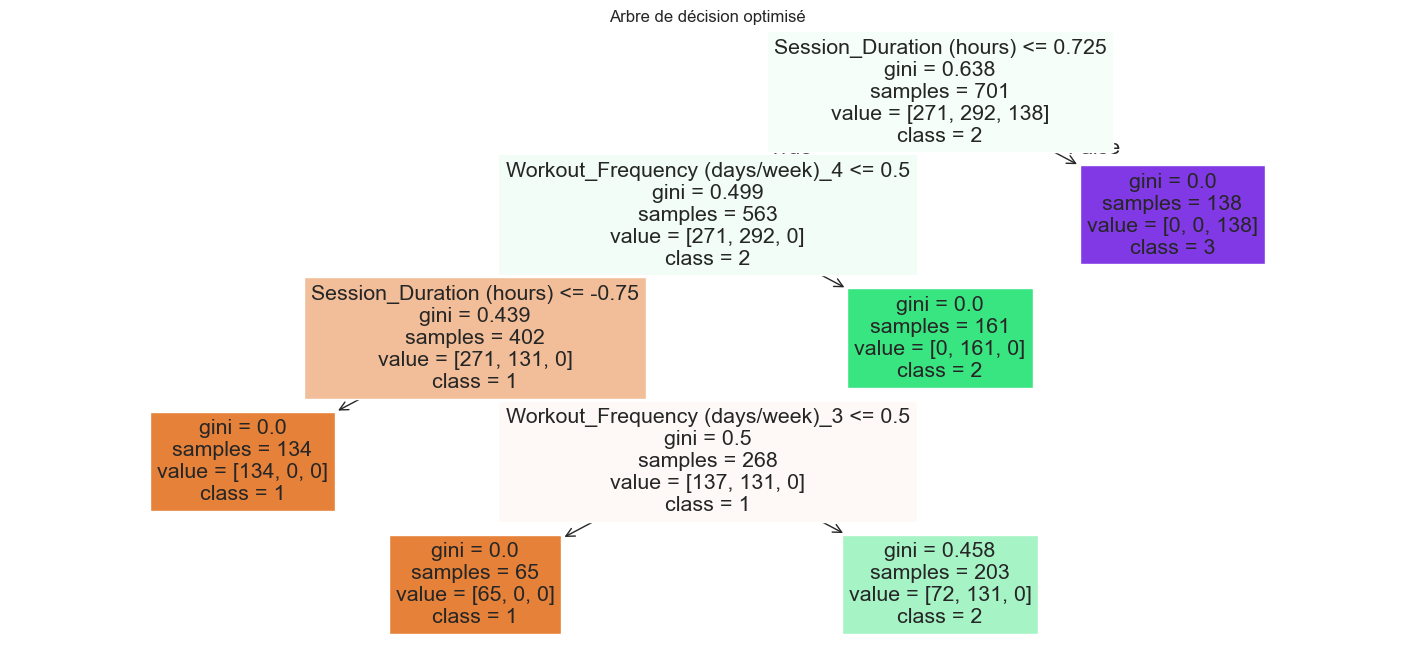

In [ ]:
# Entraînement d’un arbre de décision avec optimisation de la profondeur maximale
X_train_final, y_train_final = X_train_encoded.align(y_train, join='inner', axis=0)
param_grid_depth = {"max_depth": list(range(2, 10))}

#  optimisation profondeur de l’arbre
tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1234),
    param_grid=param_grid_depth,
    cv=10,
    n_jobs=-1
)

treeOpt = tree_grid.fit(X_train_final, y_train_final)

best_depth = treeOpt.best_params_["max_depth"]
cv_accuracy = treeOpt.best_score_
cv_error = 1 - cv_accuracy

print(f"Meilleure profondeur : {best_depth}")
print(f"Erreur moyenne (CV) : {cv_error:.4f}")

tree_final = DecisionTreeClassifier(max_depth=best_depth, random_state=1234)
tree_final.fit(X_train_final, y_train_final)

y_pred_test = tree_final.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1 - test_accuracy
print(f"Accuracy test : {test_accuracy:.4f}")
print(f"Taux d'erreur test : {100 * test_error:.2f}%")

conf_matrix = pd.crosstab(y_pred_test, y_test, rownames=["Prévu"], colnames=["Réel"])
print("Matrice de confusion :")
print(conf_matrix)

plt.figure(figsize=(18, 8))
plot_tree(tree_final, feature_names=X_train_encoded.columns, class_names=tree_final.classes_.astype(str), filled=True)
plt.title("Arbre de décision optimisé")
plt.show()


**Forêts aléatoires**

Erreur OOB (out-of-bag) : 13.98 %

Matrice de confusion (forêt brute) :
Réel    1   2   3
Prévu            
1      62  10   0
2      13  72   0
3       0   0  38

Pourcentage d'erreur : 11.79 %

Meilleur max_features : 9
Erreur moyenne (CV) : 12.70 %

Matrice de confusion (forêt optimisée) :
Réel    1   2   3
Prévu            
1      60   8   0
2      15  74   0
3       0   0  38

Pourcentage d'erreur : 11.79 %


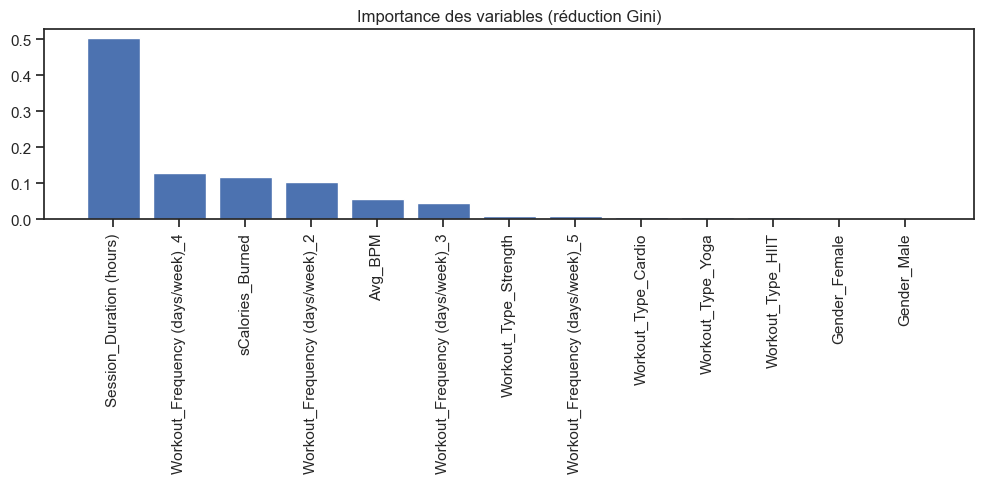


Importance décroissante des variables :
Session_Duration (hours): 0.5025
Workout_Frequency (days/week)_4: 0.1287
sCalories_Burned: 0.1180
Workout_Frequency (days/week)_2: 0.1047
Avg_BPM: 0.0572
Workout_Frequency (days/week)_3: 0.0455
Workout_Type_Strength: 0.0086
Workout_Frequency (days/week)_5: 0.0077
Workout_Type_Cardio: 0.0073
Workout_Type_Yoga: 0.0056
Workout_Type_HIIT: 0.0053
Gender_Female: 0.0046
Gender_Male: 0.0042


In [ ]:
#  forêt aléatoire : entraînement avec OOB, optimisation de max_features par validation croisée,
def erreur_pourcentage(conf_matrix):
    mat = conf_matrix.to_numpy()
    total = np.sum(mat)
    correct = np.trace(mat)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"\nPourcentage d'erreur : {pourcentage:.2f} %")

X_train_final, y_train_final = X_train_encoded.align(y_train, join='inner', axis=0)

forest_oob = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    random_state=1234,
    n_jobs=-1
)
rfFit = forest_oob.fit(X_train_final, y_train_final)

print(f"Erreur OOB (out-of-bag) : {100 * (1 - rfFit.oob_score_):.2f} %")

y_pred_rf = rfFit.predict(X_test_encoded)
conf_matrix_rf = pd.crosstab(y_pred_rf, y_test, rownames=["Prévu"], colnames=["Réel"])
print("\nMatrice de confusion (forêt brute) :")
print(conf_matrix_rf)
erreur_pourcentage(conf_matrix_rf)

param_grid = {"max_features": list(range(2, 10))}
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=1234),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
rfOpt = rf_grid.fit(X_train_final, y_train_final)

best_max_features = rfOpt.best_params_["max_features"]
print(f"\nMeilleur max_features : {best_max_features}")
print(f"Erreur moyenne (CV) : {100 * (1 - rfOpt.best_score_):.2f} %")

# Prédiction optimisée sur le test
y_pred_rf_opt = rfOpt.predict(X_test_encoded)
conf_matrix_rf_opt = pd.crosstab(y_pred_rf_opt, y_test, rownames=["Prévu"], colnames=["Réel"])
print("\nMatrice de confusion (forêt optimisée) :")
print(conf_matrix_rf_opt)
erreur_pourcentage(conf_matrix_rf_opt)

rf_importance = RandomForestClassifier(
    n_estimators=100,
    max_features=best_max_features,
    random_state=1234
)
rf_importance.fit(X_train_final, y_train_final)

importances = rf_importance.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train_final.columns

plt.figure(figsize=(10, 5))
plt.title("Importance des variables (réduction Gini)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

print("\nImportance décroissante des variables :")
for f in range(len(indices)):
    print(f"{feature_names[indices[f]]}: {importances[indices[f]]:.4f}")


**Boosting**

Boosting CV progress: 100%|██████████████████████████████████████████████████████████| 149/149 [01:34<00:00,  1.58it/s]


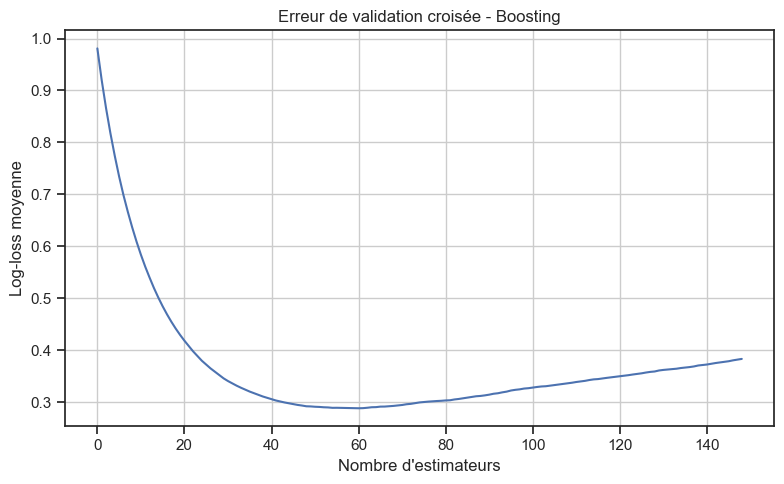

Nombre optimal d'estimateurs : 61

Matrice de confusion (Boosting) :
Prévu   0   1   2
Vrai             
0      65  10   0
1       9  73   0
2       0   0  38

Pourcentage d'erreur : 9.74 %


In [ ]:
# modélisation par Boosting 

def erreur_pourcentage(conf_matrix):
    mat = conf_matrix.to_numpy() if isinstance(conf_matrix, pd.DataFrame) else conf_matrix
    total = np.sum(mat)
    correct = np.trace(mat)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"\nPourcentage d'erreur : {pourcentage:.2f} %")

y_train_numeric = y_train.astype(int) - 1
y_test_numeric = y_test.astype(int) - 1

X_train_boost, y_train_boost = X_train_encoded.align(y_train_numeric, join='inner', axis=0)

boost_exp = HistGradientBoostingClassifier(
    loss='log_loss',
    max_iter=500,
    learning_rate=0.03,
    min_samples_leaf=5,
    random_state=1234
)

cv_scores = []
for n_trees in tqdm(range(1, 150), desc="Boosting CV progress"):
    boost_exp.set_params(max_iter=n_trees)
    scores = cross_val_score(
        boost_exp,
        X_train_boost,
        y_train_boost,
        cv=10,
        scoring='neg_log_loss',
        n_jobs=-1
    )
    cv_scores.append(-np.mean(scores))

plt.figure(figsize=(8, 5))
plt.plot(cv_scores)
plt.title("Erreur de validation croisée - Boosting")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Log-loss moyenne")
plt.grid(True)
plt.tight_layout()
plt.show()

best_iter = np.argmin(cv_scores) + 1
print(f"Nombre optimal d'estimateurs : {best_iter}")

boost_exp.set_params(max_iter=best_iter)
boost_exp.fit(X_train_boost, y_train_boost)

proba_preds = boost_exp.predict_proba(X_test_encoded)
class_preds = np.argmax(proba_preds, axis=1)

conf_matrix_boost = pd.crosstab(y_test_numeric, class_preds, rownames=["Vrai"], colnames=["Prévu"])
print("\nMatrice de confusion (Boosting) :")
print(conf_matrix_boost)
erreur_pourcentage(conf_matrix_boost)

prob_boost = boost_exp.predict_proba(X_test_encoded)


**XGBoost**

In [ ]:


data_exp_xgb = data_exp_norm.copy()
data_exp_xgb['Experience_Level'] = data_exp_xgb['Experience_Level'].astype('category').cat.codes

data_test_xgb = data_test_norm.copy()
data_test_xgb['Experience_Level'] = data_test_xgb['Experience_Level'].astype('category').cat.codes


X_train_raw = data_exp_xgb.drop(columns=['Experience_Level'])
y_train = data_exp_xgb['Experience_Level'].astype(int)

X_test_raw = data_test_xgb.drop(columns=['Experience_Level'])
y_test = data_test_xgb['Experience_Level'].astype(int)


X_train_encoded = pd.get_dummies(X_train_raw, drop_first=False)
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=False)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded, label=y_test)

# Paramètres
params = {
    'objective': 'multi:softmax',  
    'num_class': len(np.unique(y_train)),
    'max_depth': 4,
    'eta': 0.1,
    'seed': 1234,
    'verbosity': 0
}

num_round = 100
xgb_model = xgb.train(params, dtrain, num_boost_round=num_round)

preds = xgb_model.predict(dtest)

conf_matrix = confusion_matrix(y_test, preds)
conf_df = pd.DataFrame(conf_matrix,
                       index=[f"Actual {i}" for i in range(params['num_class'])],
                       columns=[f"Pred {i}" for i in range(params['num_class'])])
print(conf_df)

total = conf_matrix.sum()
correct = np.trace(conf_matrix)
error_rate = 100 * (1 - correct / total)
print(f"\nTaux d'erreur XGBoost (softmax) : {error_rate:.2f}%")


          Pred 0  Pred 1  Pred 2
Actual 0      59      16       0
Actual 1      11      71       0
Actual 2       0       0      38

Taux d'erreur XGBoost (softmax) : 13.85%


# 2.2.5 RdN

In [ ]:
# Réseau de neurones profond pour classification multi-classes avec TensorFlow
features_to_keep = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)',
    'Session_Duration (hours)', 'Avg_BPM', 'sCalories_Burned'
]
X_train_raw = data_exp_norm[features_to_keep]
y_train_raw = data_exp_norm['Experience_Level'].astype(int) - 1
X_test_raw = data_test_norm[features_to_keep]
y_test_raw = data_test_norm['Experience_Level'].astype(int) - 1
X_train_encoded = pd.get_dummies(X_train_raw, drop_first=False)
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=False)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# architecture du réseau
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train_raw,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

conf_matrix_tf = confusion_matrix(y_test_raw, y_pred_classes)
conf_df_tf = pd.DataFrame(conf_matrix_tf,
                          index=[f"Vrai {i+1}" for i in range(3)],
                          columns=[f"Prévu {i+1}" for i in range(3)])
print("\nMatrice de confusion (MLP TensorFlow) :")
print(conf_df_tf)

total = conf_matrix_tf.sum()
correct = np.trace(conf_matrix_tf)
error_rate = 100 * (1 - correct / total)
print(f"\nTaux d'erreur MLP TensorFlow : {error_rate:.2f} %")


Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3778 - loss: 1.0995 - val_accuracy: 0.7179 - val_loss: 0.9044
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6840 - loss: 0.8478 - val_accuracy: 0.7628 - val_loss: 0.6822
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7889 - loss: 0.6197 - val_accuracy: 0.8269 - val_loss: 0.4991
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8178 - loss: 0.4605 - val_accuracy: 0.8269 - val_loss: 0.3853
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.3801 - val_accuracy: 0.8141 - val_loss: 0.3488
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8587 - loss: 0.3071 - val_accuracy: 0.8141 - val_loss: 0.3290
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8896 - loss: 0.2790 - val_accuracy: 0.8013 - val_loss: 0.3301
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8472 - loss: 0.3020 - val_accuracy: 0.8205 - 

# Comparaison des méthodes

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(y_true, y_score, model_name="Modèle"):
    """
    Courbes ROC multi-classe One-vs-Rest.
    """
    y_true = np.array(y_true)
    n_classes = y_score.shape[1]

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        y_bin = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Classe {i+1} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


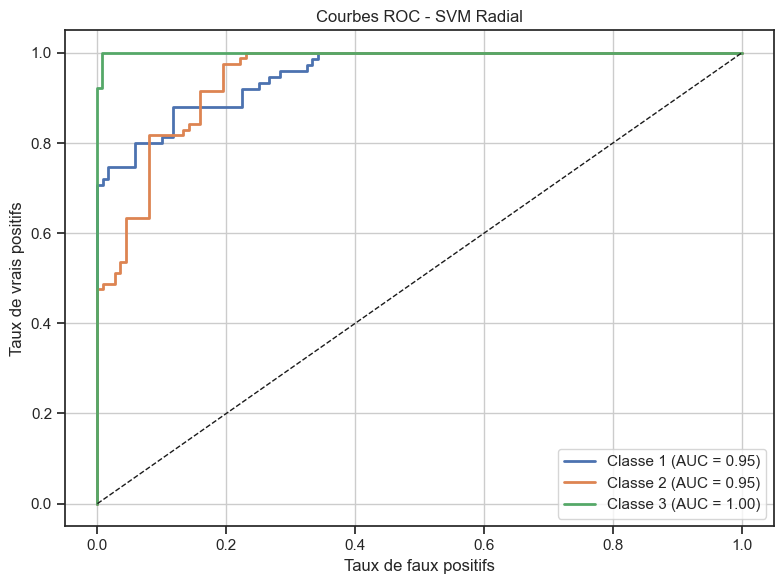

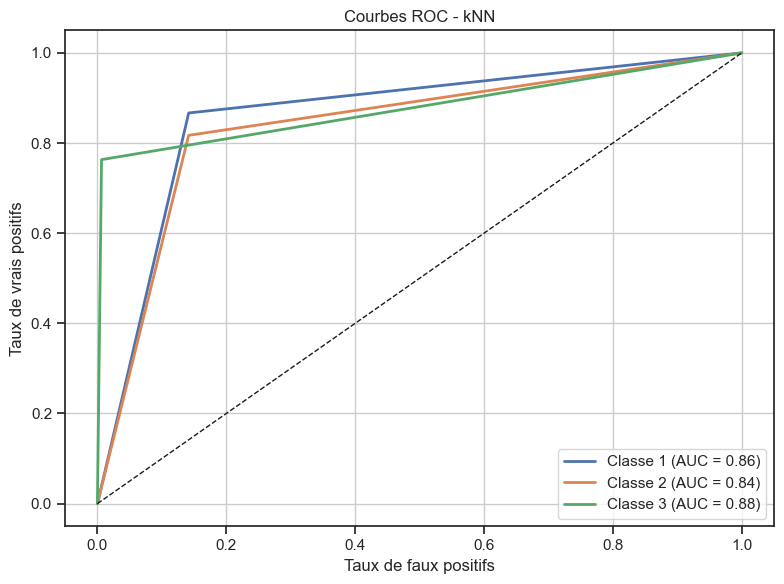

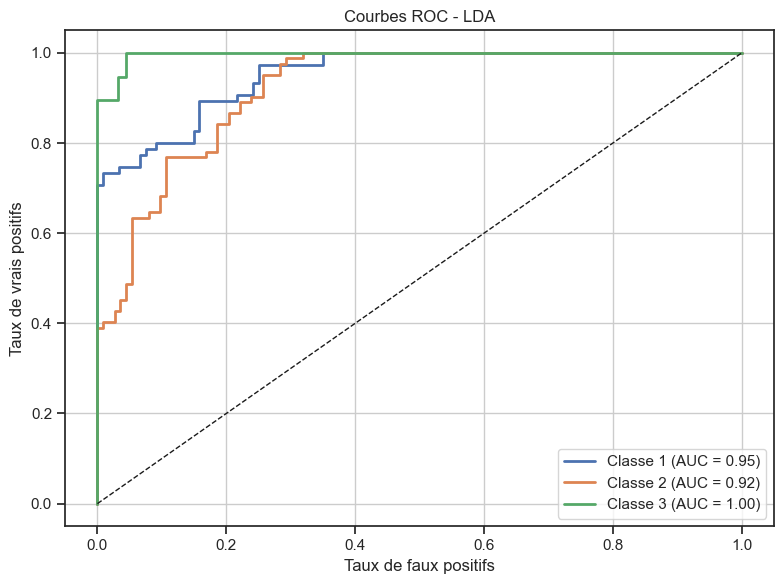

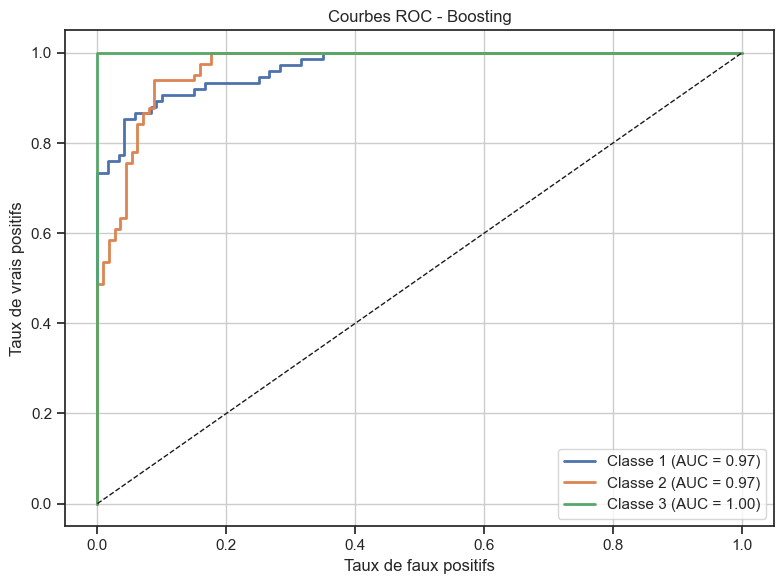

In [ ]:
plot_roc_curves(y_test_numeric, prob_svm, model_name="SVM Radial")
# ou bien
plot_roc_curves(y_test_numeric, prob_knn, model_name="kNN")
# ou bien
plot_roc_curves(y_test_numeric, probabilities_lda, model_name="LDA")
# ou bien
plot_roc_curves(y_test_numeric, prob_boost, model_name="Boosting")




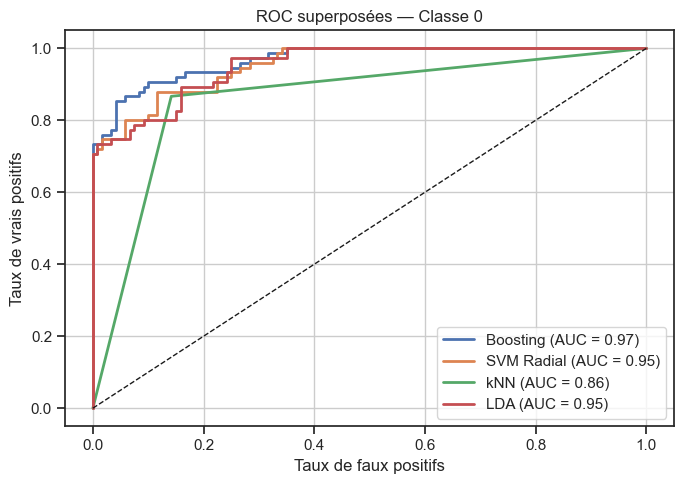

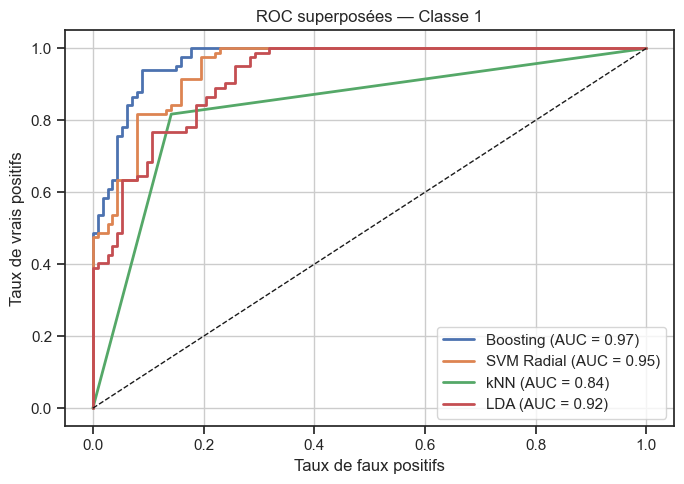

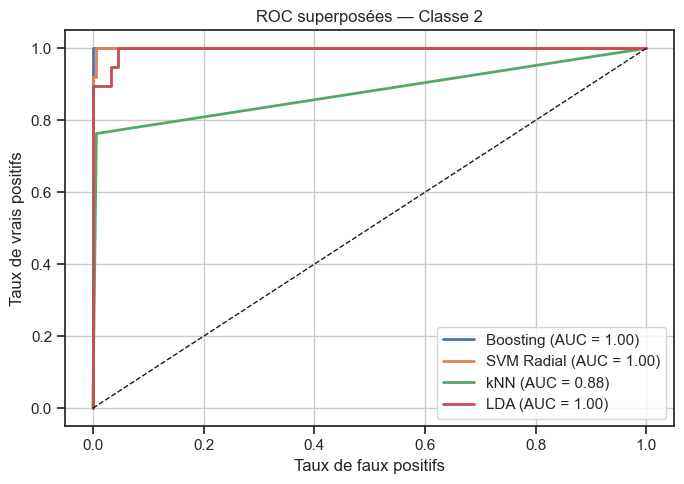

In [ ]:
def plot_all_superposed_roc(y_true, proba_ref, name_ref, proba_dict):
    """
    Affiche les courbes ROC superposées pour chaque classe,
    en comparant plusieurs modèles à un modèle de référence (Boosting par défaut).
    
    Paramètres :
    - y_true : les vraies classes numériques (0, 1, 2)
    - proba_ref : les probabilités du modèle de référence
    - name_ref : nom du modèle de référence (ex : "Boosting")
    - proba_dict : dictionnaire {nom du modèle : tableau de probas}
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    y_true = np.array(y_true)
    n_classes = proba_ref.shape[1]

    for classe in range(n_classes):
        plt.figure(figsize=(7, 5))
        y_bin = (y_true == classe).astype(int)

        # Modèle de référence
        fpr_ref, tpr_ref, _ = roc_curve(y_bin, proba_ref[:, classe])
        auc_ref = auc(fpr_ref, tpr_ref)
        plt.plot(fpr_ref, tpr_ref, lw=2, label=f"{name_ref} (AUC = {auc_ref:.2f})")

        # Les autres modèles
        for model_name, proba in proba_dict.items():
            fpr, tpr, _ = roc_curve(y_bin, proba[:, classe])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--", lw=1)
        plt.xlabel("Taux de faux positifs")
        plt.ylabel("Taux de vrais positifs")
        plt.title(f"ROC superposées — Classe {classe}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_all_superposed_roc(
    y_test_numeric,
    prob_boost,  # modèle de référence
    "Boosting",
    {
        "SVM Radial": prob_svm,
        "kNN": prob_knn,
        "LDA": probabilities_lda
    }
)

